In [141]:
# Core analysis and visualization libraries
import numpy as np
import pandas as pd
import missingno as msno
import os
import glob
import path
from itertools import chain
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns

# To determine file encoding schemes
import chardet

# For scraping species data
import requests
from bs4 import BeautifulSoup

#To determine similarity of strings
import Levenshtein 

# For querying historical weather data
from google.cloud import bigquery
from google.oauth2 import service_account

from sklearn.neighbors import BallTree, KDTree

# For geovisualization
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import plotly.express as px
from plotly.offline import init_notebook_mode
init_notebook_mode(connected = True)

# For statistical analysis
from pingouin import ttest
from scipy import stats
from patsy import dmatrix
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [ ]:
"""Unzip USGS data files containing bird observations, route and weather data"""

%%bash
cd ~/documents/Data_for_projects/Bird_data 
unzip \*.zip
# remove .zip files
rm -f *.zip

In [3]:
"""Read in survey data from each state/province"""

folder_path = '/Users/jnl741/Documents/Data_for_projects/Bird_data/USGS_Breeding_bird/2022Release_Nor/States'
file_list = glob.glob(folder_path + "/*.csv")
us_obs = pd.DataFrame(pd.read_csv(file_list[0]))
# dictionary to later convert statenums to state names
state_dict = {}
for i in range(0,len(file_list)):
    state_df = pd.read_csv(file_list[i])
    #extract state name from filename
    state_name = os.path.basename(file_list[i]).split('.')[0]
    #extract state number for dictionary, using the most common value for the column
    state_num = state_df['StateNum'].mode()[0]
    state_dict[state_num] = state_name
    us_obs = pd.concat([us_obs,state_df],axis=0)

In [96]:
us_obs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5624604 entries, 0 to 5764179
Data columns (total 11 columns):
 #   Column        Dtype  
---  ------        -----  
 0   routedataid   int64  
 1   countrynum    int64  
 2   statenum      int64  
 3   route         int64  
 4   rpid          int64  
 5   year          int64  
 6   speciestotal  int64  
 7   state         object 
 8   common_name   object 
 9   latitude      float64
 10  longitude     float64
dtypes: float64(2), int64(7), object(2)
memory usage: 514.9+ MB


<AxesSubplot:>

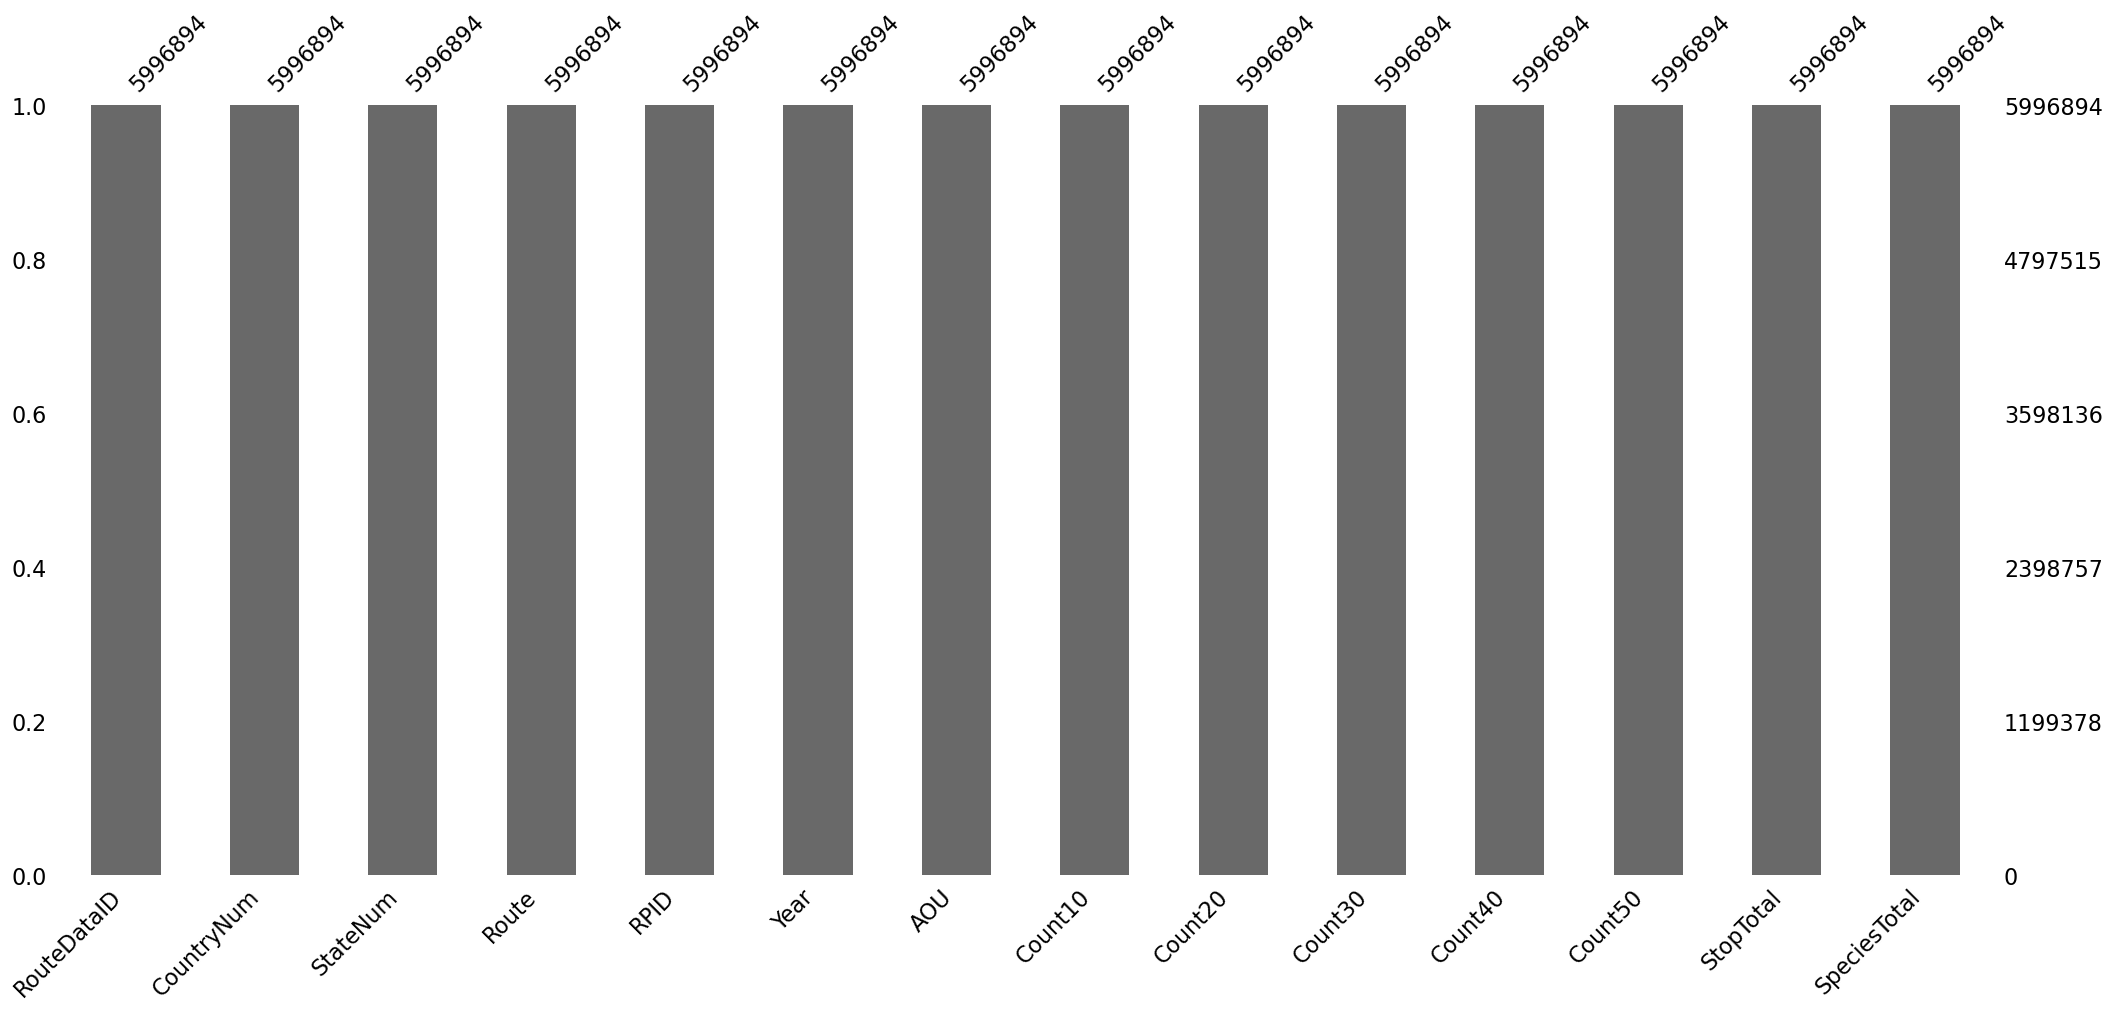

In [5]:
msno.bar(us_obs)

In [1237]:
def clean_columns (columns):
    cleaned_cols = (columns.str.lower()
                    .str.strip()
                    .str.replace(" ","_")
                    .str.replace("  ","_")
                    .str.replace("-","_")
                    .str.replace(".","_")
                    .str.replace(",","_"))
    return cleaned_cols

In [1238]:
us_obs.columns = clean_columns(us_obs.columns)

/var/folders/v9/483tmlvj28ldt2s2wvphywvxd4j0g_/T/ipykernel_93052/2975458103.py:2: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.



In [7]:
""""""
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC"}

In [8]:
"""Need to convert abbreviated state name strings to full name strings, which we will need for geovisualization. Use 
the Levenshtein distance between the abbreviated strings and full strings to find the closest match for each state. """
temp_dict = {}
for statenum,partial_name in state_dict.items():
    current_distance = 100
    for full_name in us_state_to_abbrev.keys():
        LD = Levenshtein.distance(s1 = partial_name,s2 = full_name, weights = (1,3,2))
        if LD < current_distance:
            temp_dict[statenum] = full_name
            current_distance = LD
state_dict = temp_dict


In [97]:
state_dict

{27: 'Georgia',
 92: 'Wyoming',
 80: 'South Carolina',
 81: 'South Dakota',
 83: 'Texas',
 88: 'Virginia',
 25: 'Florida',
 72: 'Pennsylvania',
 39: 'Kentucky',
 66: 'Ohio',
 50: 'Minnesota',
 17: 'Colorado',
 60: 'New Mexico',
 53: 'Montana',
 35: 'Indiana',
 58: 'New Hampshire',
 21: 'Delaware',
 77: 'Rhode Island',
 59: 'New Jersey',
 54: 'Nebraska',
 34: 'Illinois',
 47: 'Massachusetts',
 42: 'Louisiana',
 44: 'Maine',
 18: 'Connecticut',
 46: 'Maryland',
 85: 'Utah',
 82: 'Tennessee',
 89: 'Washington',
 61: 'New York',
 67: 'Oklahoma',
 14: 'California',
 51: 'Mississippi',
 52: 'Missouri',
 7: 'Arkansas',
 2: 'Alabama',
 6: 'Arizona',
 49: 'Michigan',
 55: 'Nevada',
 3: 'Alaska',
 64: 'North Dakota',
 91: 'Wisconsin',
 33: 'Idaho',
 69: 'Oregon',
 63: 'North Carolina',
 36: 'Iowa',
 87: 'Vermont',
 38: 'Kansas',
 90: 'West Virginia'}

In [10]:
"""Map revised state_dict, and then abbreviations, to df"""

us_obs['state'] = us_obs['statenum']
us_obs['state'] = us_obs['state'].map(state_dict)
us_obs['state'] = us_obs['state'].map(us_state_to_abbrev)

In [11]:
"""In order to read species names into the df, we need to scrape the species list the USGS uses from its site"""

# Create a URL object
url = 'https://www.pwrc.usgs.gov/bbl/manual/speclist.cfm'
# Create object page
species_page = requests.get(url)

# parser-lxml = Change html to Python friendly format
# Obtain page's information
soup = BeautifulSoup(species_page.text, 'lxml')
soup

# Obtain information from tag <table>
table1 = soup.find('table', id='spectbl')
table1

# Obtain column labels by targeting tag <th>
col_names = []
for i in table1.find_all('th'):
    title = i.text
    col_names.append(title)
    

In [12]:
"""Create species df"""

species_names = pd.DataFrame(columns = col_names)
#Create a for loop to fill species df
for j in table1.find_all('tr')[1:]:
    row_data = j.find_all('td')
    row = [i.text for i in row_data]
    length = len(species_names)
    species_names.loc[length] = row

species_names.columns = species_names.columns.str.lower().str.replace(' ','_')

In [13]:
"""Strip leading and trailing whitespace from'common name' and 'species_names number' strings"""
species_names['common_name'] = species_names['common_name'].str.rstrip()

species_names['species_number'] = species_names['species_number'].str.strip()


In [14]:
species_names.head()

species_number alpha_code            common_name   band_size  \
0           0010      WEGR           Western Grebe  7B, 7, 7A    
1           0011      CLGR           Clark's Grebe  7A, 7, 7B    
2           0012      WCGR   Western/Clark's Grebe     7A, 7B    
3           0020      RNGR        Red-necked Grebe  7A, 7, 7B    
4           0030      HOGR            Horned Grebe   6, 5, 5A    

                                         french_name  \
0                                     Grèbe élégant    
1                              Grèbe à face blanche    
2  Grèbe à face blanche/Grèbe élégant non identif...   
3                                     Grèbe jougris    
4                                    Grèbe esclavon    

              scientific_name t_&_e*  \
0  Aechmophorus occidentalis           
1       Aechmophorus clarkii           
2                                      
3         Podiceps grisegena           
4           Podiceps auritus      Y    

                                            comments taxonomic_order  
0                                                                 97  
1                                                                 99  
2  Unspecified Aechmophorus occidentalis or A. cl...              98  
3                                                                 95  
4  Magdalen Islands population is endangered. | L...              94

In [1870]:
#save species df as csv
species_names.to_csv('/Users/jnl741/Documents/Data_for_projects/Bird_data/USGS_Breeding_bird/USGS species code.csv')

In [15]:
species_dict = dict(zip(species_names['species_number'],species_names['common_name']))

us_obs['aou'] = us_obs['aou'].astype(str)

us_obs['common_name'] = us_obs['aou']
us_obs['common_name'] = us_obs['common_name'].map(species_dict)

pd.options.display.max_columns = 100
us_obs.head()

routedataid  countrynum  statenum  route  rpid  year   aou  count10  \
0      6170703         840        27      1   101  1970  1840        1   
1      6170703         840        27      1   101  1970  1960        0   
2      6170703         840        27      1   101  1970  2000        0   
3      6170703         840        27      1   101  1970  2001        1   
4      6170703         840        27      1   101  1970  2110        1   

   count20  count30  count40  count50  stoptotal  speciestotal state  \
0        0        0        0        0          1             1    GA   
1        1        1        2        1          4             5    GA   
2        0        0        0        1          1             1    GA   
3        0        1        0        0          2             2    GA   
4        0        0        0        0          1             1    GA   

         common_name  
0         White Ibis  
1        Great Egret  
2  Little Blue Heron  
3       Cattle Egret  
4       Clapper Rail

<AxesSubplot:>

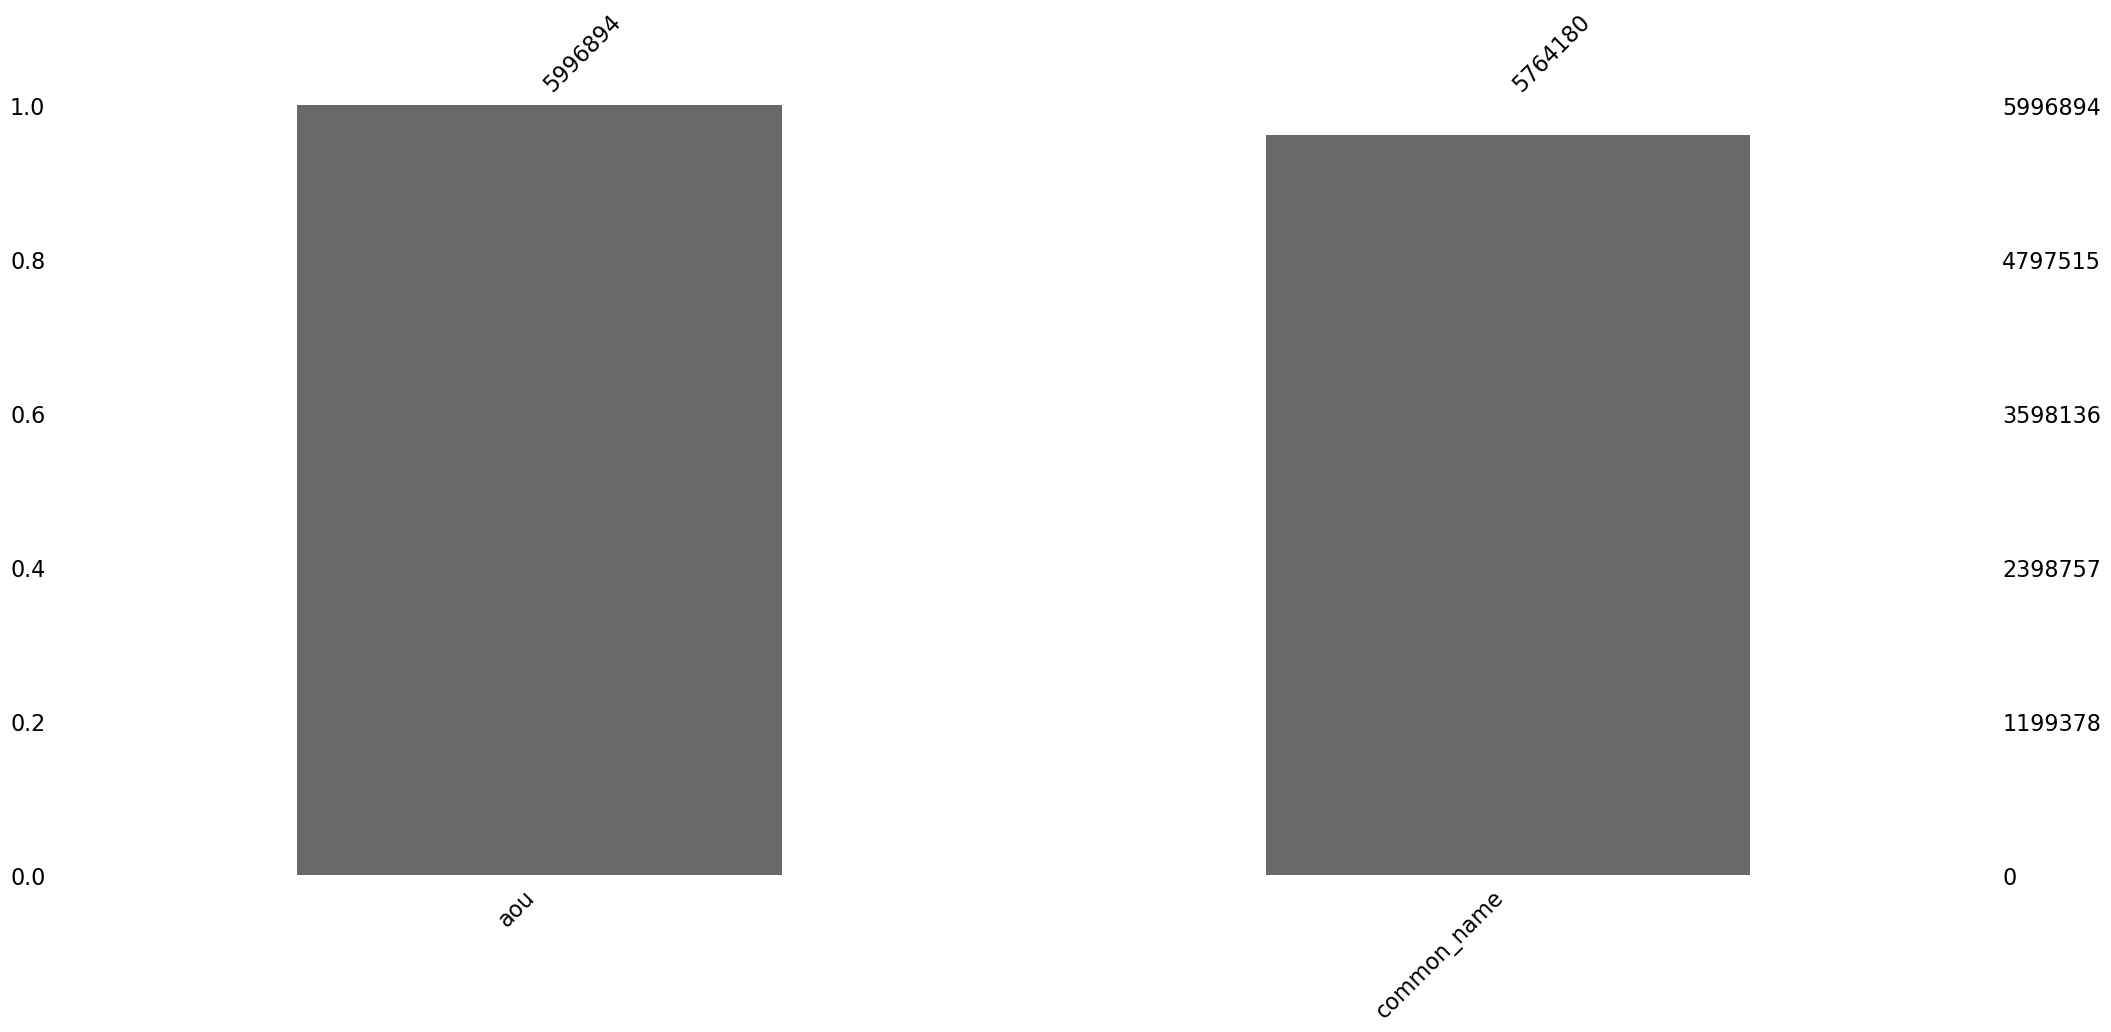

In [16]:
"""Visualize missing values for aou/common_name to determine completeness of mapping"""
msno.bar(us_obs[['aou','common_name']])


In [17]:
"""There are a small number of missing species names in the 'common_name' column. What are the corresponding aou 
codes? """
pd.options.display.max_rows = 1000
us_obs[us_obs['common_name'].isnull()]['aou'].value_counts()


3131     47833
2890     45005
3091     27445
3100     18680
22860    13062
2940      7542
540       6295
60        4752
70        3704
3000      3679
2930      3374
5738      3309
510       3153
580       2969
2920      2748
770       2597
2950      2469
530       2342
2881      1918
690       1658
4881      1564
3080      1525
2882      1327
10        1258
40        1163
640       1138
590       1132
550       1085
740       1047
3090       923
440        921
2971       844
3050       632
534        622
710        611
650        603
5739       594
470        530
20         508
700        484
490        476
800        472
230        406
3451       380
4865       369
630        346
11         317
2970       299
3010       293
12         271
4665       271
110        270
100        259
290        248
4022       243
380        232
600        226
5275       220
4689       195
420        187
3333       185
1861       167
6122       161
30         161
7351       157
4642       153
2960      

In [18]:
"""Because there is no precise way of resolving these incorrect aou values, drop the corresponding rows
from the dataframe"""

us_obs = us_obs[~us_obs['common_name'].isnull()]

In [19]:
"""Read in info about routes, including lat/long and weather data"""

#Get text file format with Chardet
with open('/Users/jnl741/Documents/Data_for_projects/Bird_data/USGS_Breeding_bird/2022Release_Nor/routes.csv', 
          'rb') as rawdata:
    enc_scheme = chardet.detect(rawdata.read(100000))
enc_scheme

{'encoding': 'ISO-8859-1', 'confidence': 0.73, 'language': ''}

In [20]:
routes = pd.read_csv('/Users/jnl741/Documents/Data_for_projects/Bird_data/USGS_Breeding_bird/2022Release_Nor/routes.csv',
                    encoding = enc_scheme['encoding'])
routes.columns = routes.columns.str.lower()
routes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5784 entries, 0 to 5783
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   countrynum         5784 non-null   int64  
 1   statenum           5784 non-null   int64  
 2   route              5784 non-null   int64  
 3   routename          5784 non-null   object 
 4   active             5784 non-null   int64  
 5   latitude           5784 non-null   float64
 6   longitude          5784 non-null   float64
 7   stratum            5784 non-null   int64  
 8   bcr                5784 non-null   int64  
 9   routetypeid        5784 non-null   int64  
 10  routetypedetailid  5784 non-null   int64  
dtypes: float64(2), int64(8), object(1)
memory usage: 497.2+ KB


In [21]:
"""Merge us_obs and routes"""
us_obs = us_obs.merge(right = routes, how = 'inner', on = ['statenum','route'], suffixes = ["", "_y"])
us_obs = us_obs.drop(us_obs.filter(regex = '_y$').columns, axis = 1)


In [24]:
"""Confirm that speciestotal is the sum of the count# columns before deleting count# columns"""
us_obs[us_obs['speciestotal'] != us_obs[['count10','count20','count30','count40','count50']].sum(axis = 1)]

Empty DataFrame
Columns: [routedataid, countrynum, statenum, route, rpid, year, aou, count10, count20, count30, count40, count50, stoptotal, speciestotal, state, common_name, routename, active, latitude, longitude, stratum, bcr, routetypeid, routetypedetailid]
Index: []

In [25]:
"""To reduce memory usage, drop columns that aren't necessary for subsequent analysis."""

us_obs = us_obs.drop(columns = ['count10', 
                                'count20',
                                'count30',
                                'count40',
                                'count50',
                                'aou',
                                'stoptotal',
                                'routename',
                                'active',
                                'bcr',
                                'stratum',
                                'routetypeid',
                                'routetypedetailid'])

In [26]:
"""Confirm that the coordinates of the USGS breeding bird survey observations are all within the continental US and
Alaska."""
#Import world map shapefile as GeoPandas df.
world = gpd.read_file('/Users/jnl741/Downloads/World_Countries/World_Countries.shp')
world.head()

FID         COUNTRY ISO     COUNTRYAFF AFF_ISO  SHAPE_Leng  SHAPE_Area  \
0    1     Afghanistan  AF    Afghanistan      AF   50.803210   62.566714   
1    2         Albania  AL        Albania      AL    9.625038    3.073540   
2    3         Algeria  DZ        Algeria      DZ   70.540082  213.513461   
3    4  American Samoa  AS  United States      US    0.600124    0.013720   
4    5         Andorra  AD        Andorra      AD    0.937352    0.055585   

                                            geometry  
0  POLYGON ((61.27655 35.60725, 61.29638 35.62854...  
1  POLYGON ((19.57083 41.68527, 19.58195 41.69569...  
2  POLYGON ((4.60335 36.88791, 4.63555 36.88638, ...  
3  POLYGON ((-170.74390 -14.37555, -170.74942 -14...  
4  POLYGON ((1.44584 42.60194, 1.48653 42.65042, ...

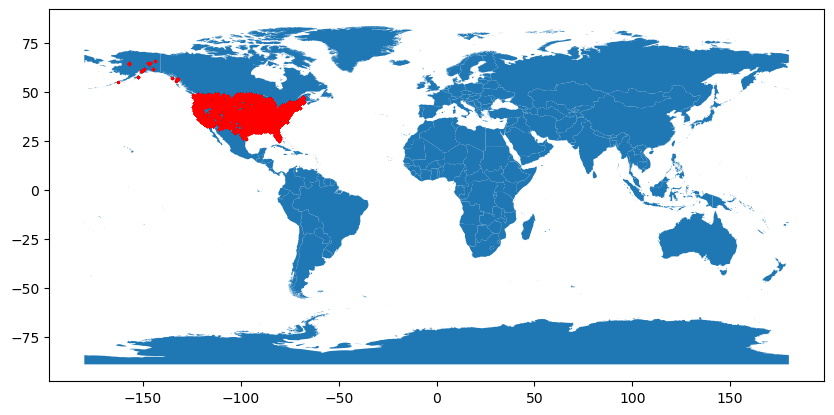

In [27]:
#Plot world map and USGS observations by lat,lon
ax = world.plot(figsize = (10,10))
ax.scatter(y = us_obs.query('year == 1988')['latitude'], 
           x = us_obs.query('year == 1988')['longitude'],
           color = 'r',
           s = 1.5)

In [28]:
"""Eliminate Alaska from the analysis, as it is incompletely sampled and could bias range estimates northwards."""

us_obs = us_obs.query('statenum != 3')

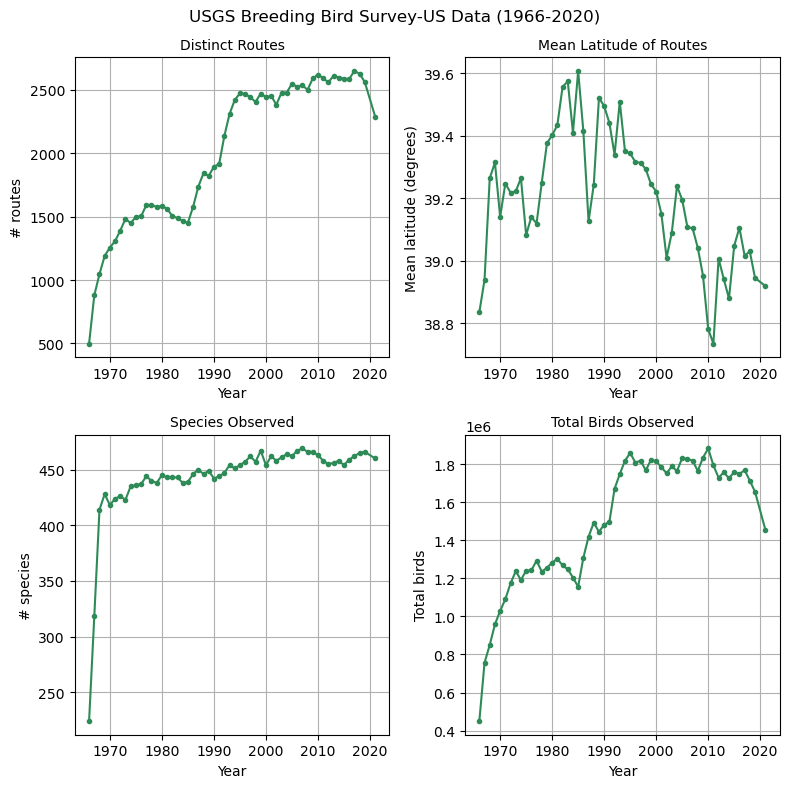

In [29]:
"""Visualize trends in route/observation data in us_obs"""

fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (8,8))
fig.suptitle('USGS Breeding Bird Survey-US Data (1966-2020)')

us_obs.groupby('year').agg('nunique')['routedataid'].plot(color = 'seagreen', ax = axs[0][0], marker = '.')
axs[0][0].set_title('Distinct Routes', size = 10)
axs[0][0].set_xlabel('Year')
axs[0][0].set_ylabel('# routes')
axs[0][0].grid()

us_obs.query('statenum !=3').groupby('year').agg(np.mean)['latitude'].plot(color = 'seagreen', ax = axs[0][1], marker = '.')
axs[0][1].set_title('Mean Latitude of Routes', size = 10)
axs[0][1].set_xlabel('Year')
axs[0][1].set_ylabel('Mean latitude (degrees)')
axs[0][1].grid()

us_obs.groupby('year').agg('nunique')['common_name'].plot(color = 'seagreen', ax = axs[1][0], marker = '.')
axs[1][0].set_title('Species Observed', size = 10)
axs[1][0].set_xlabel('Year')
axs[1][0].set_ylabel('# species')
axs[1][0].grid()

us_obs.groupby('year').agg(np.sum)['speciestotal'].plot(color = 'seagreen', ax = axs[1][1], marker = '.')
axs[1][1].set_title('Total Birds Observed', size = 10)
axs[1][1].set_xlabel('Year')
axs[1][1].set_ylabel('Total birds')
axs[1][1].grid()

plt.tight_layout()

In [79]:
us_obs = us_obs.query('year >= 1968')

In [31]:
"""Read in observations from Canada"""
folder_path = '/Users/jnl741/Documents/Data_for_projects/Bird_data/USGS_Breeding_bird/2022Release_Nor/Canada'
file_list = glob.glob(folder_path + "/*.csv")
canada_obs = pd.DataFrame(pd.read_csv(file_list[0]))
# dictionary to later convert province nums to province names
province_dict = {}
for i in range(0,len(file_list)):
    canada_df = pd.read_csv(file_list[i])
    #extract state name from filename
    province_name = os.path.basename(file_list[i]).split('.')[0]
    #extract state number for dictionary, using the most common value for the column
    province_num = canada_df['StateNum'].mode()[0]
    province_dict[province_num] = province_name
    canada_obs = pd.concat([canada_obs,canada_df],axis=0)

In [32]:
canada_obs.head()

RouteDataID  CountryNum  StateNum  Route  RPID  Year   AOU  Count10  \
0      6174579         124        11      1   101  1974   440        3   
1      6174579         124        11      1   101  1974  1940        1   
2      6174579         124        11      1   101  1974  2940        2   
3      6174579         124        11      1   101  1974  3091        3   
4      6174579         124        11      1   101  1974  3900        1   

   Count20  Count30  Count40  Count50  StopTotal  SpeciesTotal  
0        0        0        0        0          1             3  
1        0        0        0        0          1             1  
2        1        1        0        0          4             4  
3        3        0        0        0          4             6  
4        0        0        0        0          1             1

In [34]:
canada_obs.columns = canada_obs.columns.str.lower()

In [35]:
species_dict = dict(zip(species_names['species_number'],species_names['common_name']))

canada_obs['aou'] = canada_obs['aou'].astype(str)

canada_obs['common_name'] = canada_obs['aou']
canada_obs['common_name'] = canada_obs['common_name'].map(species_dict)

pd.options.display.max_columns = 100
canada_obs.head()

routedataid  countrynum  statenum  route  rpid  year   aou  count10  \
0      6174579         124        11      1   101  1974   440        3   
1      6174579         124        11      1   101  1974  1940        1   
2      6174579         124        11      1   101  1974  2940        2   
3      6174579         124        11      1   101  1974  3091        3   
4      6174579         124        11      1   101  1974  3900        1   

   count20  count30  count40  count50  stoptotal  speciestotal  \
0        0        0        0        0          1             3   
1        0        0        0        0          1             1   
2        1        1        0        0          4             4   
3        3        0        0        0          4             6   
4        0        0        0        0          1             1   

         common_name  
0                NaN  
1   Great Blue Heron  
2                NaN  
3                NaN  
4  Belted Kingfisher

In [36]:
"""Merge canada_obs and routes"""
canada_obs = canada_obs.merge(right = routes, how = 'inner', on = ['statenum','route'], suffixes = ["", "_y"])
canada_obs = canada_obs.drop(canada_obs.filter(regex = '_y$').columns, axis = 1)


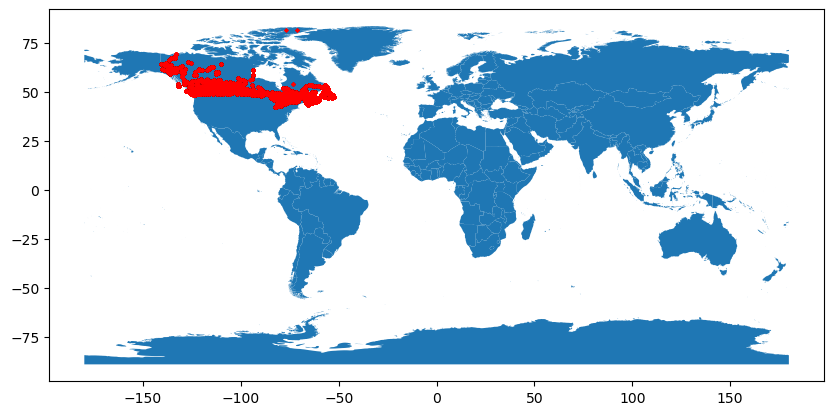

In [38]:
"""Confirm that all observations in canada_obs are in Canada"""
ax = world.plot(figsize = (10,10))
ax.scatter(y = canada_obs['latitude'], 
           x = canada_obs['longitude'],
           color = 'r',
           s = 2)

In [39]:
"""Confirm that speciestotal is the sum of the count# columns before deleting count# columns"""
canada_obs[canada_obs['speciestotal'] != canada_obs[['count10','count20','count30','count40','count50']].sum(axis = 1)]


Empty DataFrame
Columns: [routedataid, countrynum, statenum, route, rpid, year, aou, count10, count20, count30, count40, count50, stoptotal, speciestotal, common_name, routename, active, latitude, longitude, stratum, bcr, routetypeid, routetypedetailid]
Index: []

In [40]:
"""To reduce memory usage, drop columns that aren't necessary for subsequent analysis."""

canada_obs = canada_obs.drop(columns = ['count10', 
                                'count20',
                                'count30',
                                'count40',
                                'count50',
                                'aou',
                                'stoptotal',
                                'routename',
                                'active',
                                'bcr',
                                'stratum',
                                'routetypeid',
                                'routetypedetailid'])

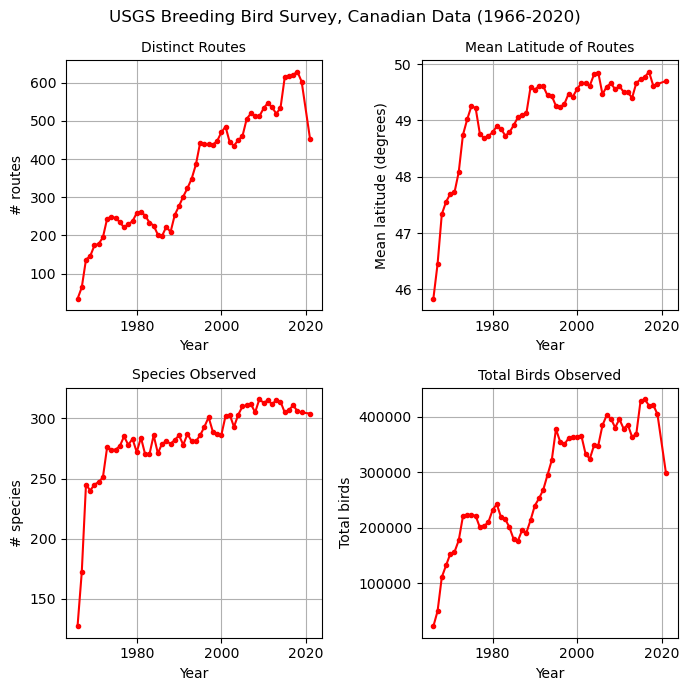

In [41]:
"""Visualize trends in route/observation data in canada_obs"""

fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (7,7))
fig.suptitle('USGS Breeding Bird Survey, Canadian Data (1966-2020)')

canada_obs.groupby('year').agg('nunique')['routedataid'].plot(color = 'red', ax = axs[0][0], marker = '.')
axs[0][0].set_title('Distinct Routes', size = 10)
axs[0][0].set_xlabel('Year')
axs[0][0].set_ylabel('# routes')
axs[0][0].grid()

canada_obs.groupby('year').agg(np.mean)['latitude'].plot(color = 'red', ax = axs[0][1], marker = '.')
axs[0][1].set_title('Mean Latitude of Routes', size = 10)
axs[0][1].set_xlabel('Year')
axs[0][1].set_ylabel('Mean latitude (degrees)')
axs[0][1].grid()

canada_obs.groupby('year').agg('nunique')['common_name'].plot(color = 'red', ax = axs[1][0], marker = '.')
axs[1][0].set_title('Species Observed', size = 10)
axs[1][0].set_xlabel('Year')
axs[1][0].set_ylabel('# species')
axs[1][0].grid()

canada_obs.groupby('year').agg(np.sum)['speciestotal'].plot(color = 'red', ax = axs[1][1], marker = '.')
axs[1][1].set_title('Total Birds Observed', size = 10)
axs[1][1].set_xlabel('Year')
axs[1][1].set_ylabel('Total birds')
axs[1][1].grid()

plt.tight_layout()

In [80]:
"""Given the small number of species observed in the first two years drop the corresponding data"""
canada_obs = canada_obs.query('year >= 1968')

In [160]:
""" Merging these two large datasets will be very memory-intensive, so filter out the Canadian obs of species
not in the US dataframe, and then concatenate."""

#Keep records of species only present in US dataset.
canada_obs = canada_obs[canada_obs['common_name'].isin(us_obs.common_name.unique())]

#Concatenate US and Canadian dfs
us_canada_obs = pd.concat([us_obs, canada_obs])

In [161]:
"""Rename countrynum and replace numeric value with 'US' & CAN."""

us_canada_obs.rename(columns = {'countrynum':'country'}, inplace = True)
us_canada_obs['country'] = us_canada_obs['country'].map({840:'US',124:'CAN'})

In [115]:
"""Connect to and query the NOAA GSOD database on Google BigQuery to obtain historical weather data  We want weather 
data from the continental US, for month of June, spanning the years of the USGS breeding bird survey (1966-2021)."""

credentials = service_account.Credentials.from_service_account_file(
'/Users/jnl741/Downloads/climate-data-for-usgs-proj-4c3cc04e7474.json')

project_id = 'my-bq'
client = bigquery.Client(credentials = credentials, project = project_id)

# Start BigQuery client
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/Users/jnl741/Downloads/climate-data-for-usgs-proj-4c3cc04e7474.json"
client = bigquery.Client()        

# Query
QUERY = ("""SELECT 
            st.usaf, 
            st.wban, 
            st.state, 
            st.lat, 
            st.lon, 
            w.stn, 
            w.wban, 
            w.year, 
            w.mo, 
            AVG(dewp) as Dewpoint,
            AVG(`max`) as max_temp, 
            AVG(`min`) AS min_temp, 
            AVG(prcp) AS Precipitation
FROM `bigquery-public-data.noaa_gsod.stations`  st
INNER JOIN  `bigquery-public-data.noaa_gsod.gsod*` w 
    ON 
    w.stn = st.usaf AND w.wban = st.wban
WHERE _TABLE_SUFFIX BETWEEN "1966" AND "2021" 
    AND st.country IN ("US" , "CA")
    AND st.state NOT IN ("AK", "HI", "PR")
    AND mo = "06"
GROUP BY w.stn, st.usaf, w.wban,st.wban, st.state, st.lat, st.lon, w.stn, w.mo,w.year
ORDER BY year"""
)

# Start Query API Request
query_job = client.query(QUERY)   
# Get Query Result
query_result = query_job.result()  
# Save the query result to Dataframe
NOAA_weather_original = query_result.to_dataframe()  

In [883]:
"""Since we will use latitude/longitude coordinates to match weather records to bird observations, let's drop rows 
in the NOAA df with null lat/lon."""

NOAA_weather = NOAA_weather_original[~NOAA_weather_original['lat'].isnull()]

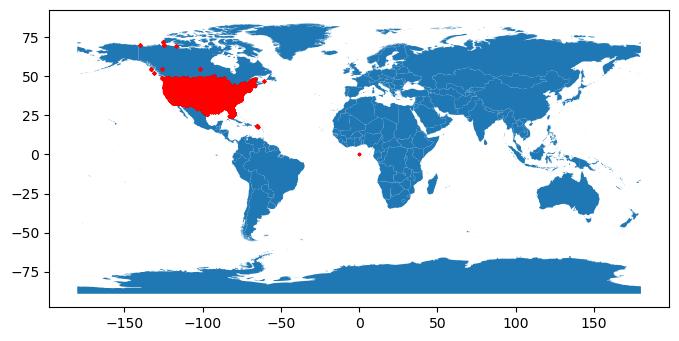

In [884]:
"""Plot weather data by lat/long"""

geometry = [Point(xy) for xy in zip(NOAA_weather['lon'], NOAA_weather['lat'])]
gdf = GeoDataFrame(NOAA_weather, 
                   geometry = geometry) 
gdf.plot(ax = world.plot(figsize=(8,8)), 
         marker = 'o', color = 'red', 
         markersize = 2);

In [885]:
"""Given how few monitoring sites are in Canada, drop Canadian observations"""

NOAA_weather = NOAA_weather[NOAA_weather['state'].isin(list(us_state_to_abbrev.values()))]

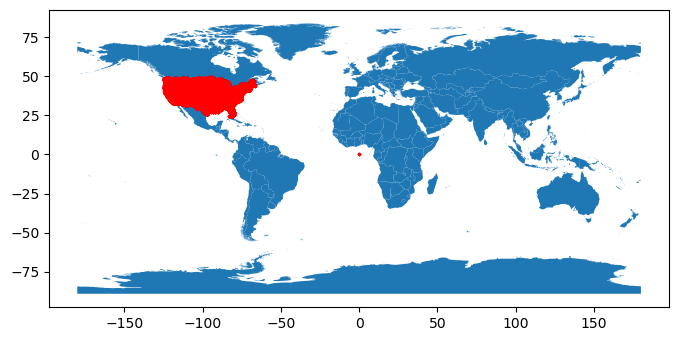

In [886]:
"""Plot weather data by lat/long"""

geometry = [Point(xy) for xy in zip(NOAA_weather['lon'], NOAA_weather['lat'])]
gdf = GeoDataFrame(NOAA_weather, 
                   geometry = geometry) 
gdf.plot(ax = world.plot(figsize=(8,8)), 
         marker = 'o', color = 'red', 
         markersize = 2);

In [887]:
"""Group NOAA_weather by year"""

weather_grouped = NOAA_weather.groupby(by = 'year').agg(np.mean)[['max_temp','min_temp']]
weather_grouped

max_temp    min_temp
year                        
1966   82.025846   60.750237
1967   80.932251   62.056057
1968   81.956018   63.279684
1969   82.238174   61.233225
1970   83.791804   63.242695
1971   83.534703   62.831129
1972   81.406590   62.422093
1973   91.497926   87.974355
1974   86.928689   91.332694
1975   86.671294   73.875266
1976   97.649566   87.167537
1977   86.814147   73.986817
1978   87.021133   76.518708
1979   85.407211   73.550026
1980   82.205657   74.219922
1981   87.387149   77.202636
1982   93.616253   77.588096
1983   86.022936   68.854879
1984   97.477666   82.792935
1985   86.874819   78.138084
1986   97.981686   83.890203
1987  102.064306   87.939599
1988  130.367120  109.601040
1989  124.792690   98.994399
1990   92.508671   88.391174
1991   85.566119   79.580707
1992   89.187718   94.091132
1993  117.909340  109.891964
1994  119.420548  123.051568
1995  138.619189  123.394637
1996  104.462536  104.526244
1997   84.633658   65.801616
1998   88.347230   68.276513
1999   95.687032   77.032271
2000   87.010772   66.292772
2001   89.560901   68.086201
2002   87.493950   66.937572
2003   90.310938   68.984477
2004   86.478402   64.325670
2005   88.221941   68.692354
2006   88.131368   68.672332
2007   87.001771   69.598454
2008   85.568720   66.835797
2009   84.816539   63.190355
2010   86.491623   68.867668
2011   86.919738   73.559672
2012   91.346396   73.116294
2013   87.215372   70.343181
2014   91.180428   69.810253
2015   96.216119   79.209897
2016   91.911562   69.968140
2017   87.695653   67.701449
2018   90.450243   68.537957
2019   88.127247   66.550812
2020   92.128155   68.645411
2021   88.733479   66.991028

<AxesSubplot:xlabel='max_temp', ylabel='Count'>

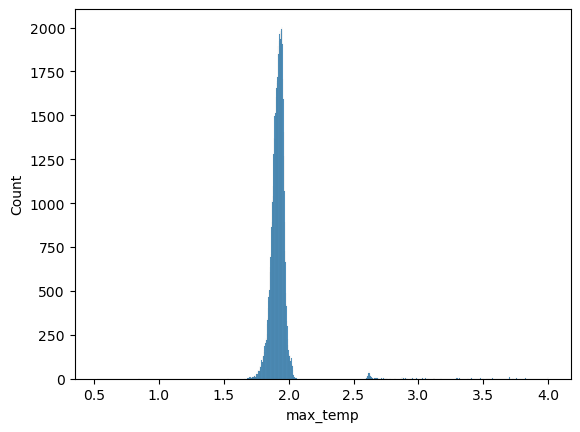

In [888]:
"""Some years, like 1988, 1989 and 1993-96 have improbably high average max temperatures. Plot the max temps 
by location for the entire dataset to investigate the range of values"""

#Log scale to accommodate large values
sns.histplot(np.log10(NOAA_weather['max_temp']))

<AxesSubplot:xlabel='max_temp', ylabel='Count'>

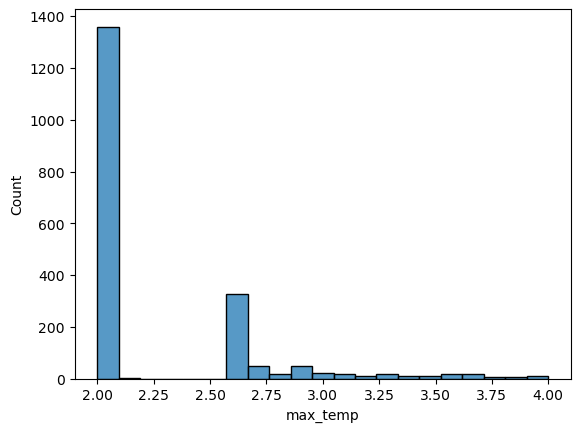

In [889]:
"""Establish cutoff for removing extreme data"""
sns.histplot(np.log10(NOAA_weather[np.log10(NOAA_weather['max_temp']) > 2.0]['max_temp']))

In [890]:
"""Remove data that is at or above 10^2.1 degrees F."""

NOAA_weather = NOAA_weather[NOAA_weather['max_temp'] <= 10**2.1]

<AxesSubplot:xlabel='max_temp', ylabel='Count'>

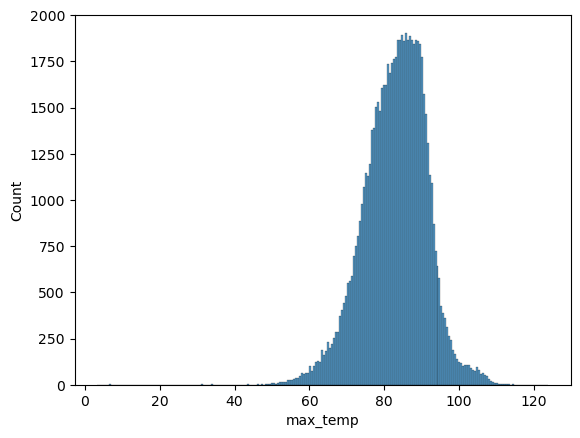

In [893]:
sns.histplot(NOAA_weather['max_temp'])

<AxesSubplot:xlabel='mo', ylabel='max_temp'>

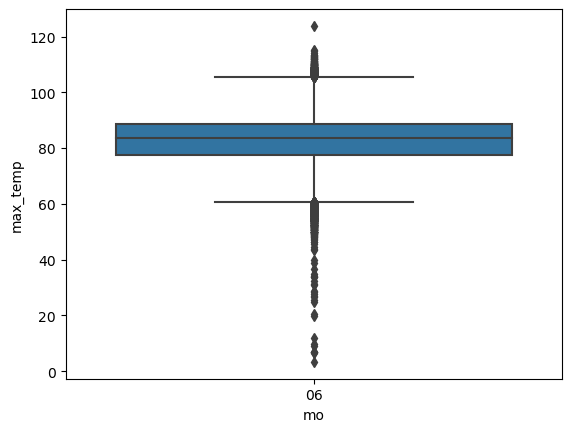

In [894]:
sns.boxplot(y = NOAA_weather['max_temp'], 
           x = NOAA_weather['mo'])

/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:693: UserWarning:

The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.



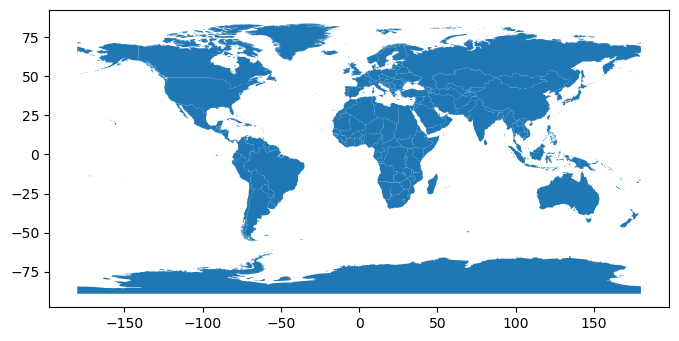

In [1239]:
"""Visualize locations of extreme low max_temps"""

geometry = [Point(xy) for xy in zip(NOAA_weather.query('max_temp < 40')['lon'], NOAA_weather.query('max_temp < 40')['lat'])]
gdf = GeoDataFrame(NOAA_weather.query('max_temp < 40'), 
                   geometry = geometry) 
gdf.plot(ax = world.plot(figsize=(8,8)), 
         marker = 'o', color = 'red', 
         markersize = 2);

In [904]:
"""Drop observations less than or equal to 40 degrees """

NOAA_weather = NOAA_weather.query('max_temp >= 40')

In [956]:
NOAA_weather.query('year == "1970"')['max_temp']

1904     73.292308
1905     75.290000
1906     72.820000
1907     75.306667
1908     88.596667
1909     87.036667
1910     80.620000
1911     73.273333
1912     78.073333
1913     77.780000
1914     82.626667
1915     87.776667
1916     83.496667
1917     77.490000
1918     81.283333
1919     79.076667
1920     75.576667
1921     79.796667
1923     80.313333
1924     82.583333
1925     92.263333
1926     88.076667
1927     80.473333
1928     79.880000
1929     85.283333
1930     86.380000
1931     75.660000
1932     88.913333
1933     87.693333
1934     83.940000
1935     87.760000
1936     86.793333
1937     93.663333
1938     88.750000
1939     76.990000
1940     79.076667
1941     79.076667
1942     79.030000
1943     84.463333
1944     82.856667
1945     88.000000
1946     84.586667
1947     80.823333
1948     75.233333
1949     83.686667
1950     93.383333
1951     88.023333
1952     88.496667
1953     84.200000
1954     79.756667
1955     86.493333
1956     74.292308
1957     80.

In [971]:


weather_avg = NOAA_weather.query('year >= "1975"').groupby(by = 'year').agg(np.mean)[['max_temp','min_temp']]

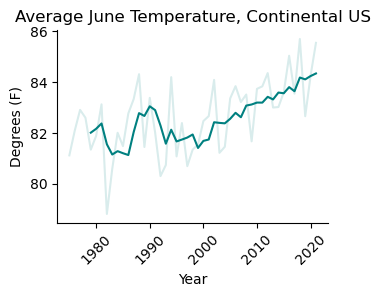

In [1217]:
"""Plot mean max_temp over time"""

# Smooth with a 5-year rolling window
fig,axs = plt.subplots(figsize = (3.5,2.5))
axs.plot(weather_avg.index.astype(int), weather_avg['max_temp'].rolling(5).mean(), color = 'teal')
plt.xticks(rotation = 45)
axs.set_xlabel('Year')
axs.set_ylabel('Degrees (F)')
axs.locator_params(nbins=10, axis='x')
axs.set_title('Average June Temperature, Continental US', size = 10)
axs.set_xticks([1980, 1990, 2000, 2010, 2020])

#Raw data
axs.plot(weather_avg.index.astype(int), weather_avg['max_temp'], color = 'teal', alpha = 0.15)
plt.xticks(rotation = 45)
axs.set_xlabel('Year')
axs.set_ylabel('Degrees (F)')
axs.locator_params(nbins=10, axis='x')
axs.set_title('Average June Temperature, Continental US', size = 12)
axs.set_xticks([1980, 1990, 2000, 2010, 2020])
sns.despine();

In [ ]:
"""Looks like there is no net change in mean temperature until the late 80's/early 90s"""

In [162]:
"""Pare down us_canada_obs to conserve memory"""

us_canada_obs = us_canada_obs.query('year >= 1975')

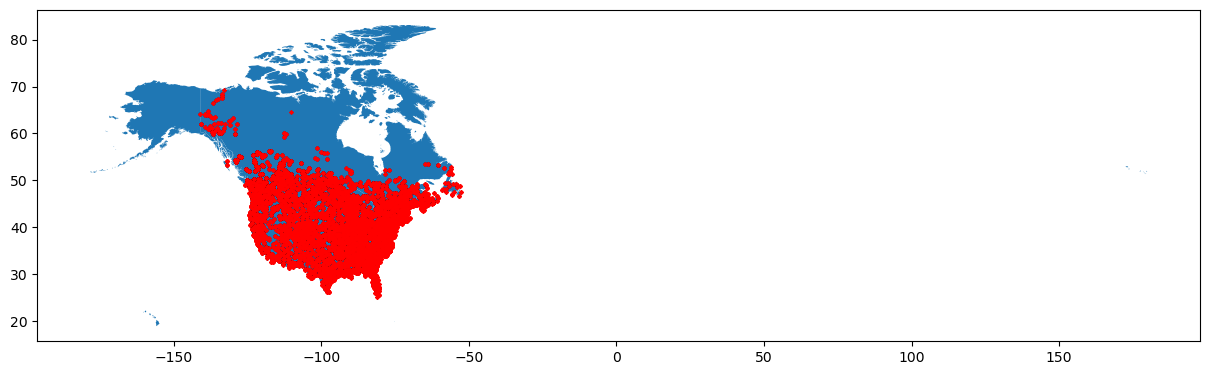

In [317]:
"""Plot world map and USGS observations by lat,lon to ascertain if there any patterns in the data"""
ax = world.query('COUNTRY == "United States"|COUNTRY =="Canada"').plot(figsize = (15,15))

yr = 2019

ax.scatter(y = us_canada_obs.query('year == @yr')['latitude'], 
           x = us_canada_obs.query('year == @yr')['longitude'],
           color = 'r',
           s = 2)


Looks like coverage in the western US is sparse for most of the dataset, as is coverage in northern Canada. Species
should therefore be chose that have ranges within these boundaries.

In [168]:
"""Visualize species maps to ensure that they make sense, and determine that they are within bounds"""

species_yr = us_canada_obs.query("""year == 2016 & common_name == "California Scrub-Jay" """)

fig = px.scatter_geo(data_frame = species_yr, 
                     lat = 'latitude', 
                     lon = 'longitude',
                     color = 'speciestotal',
                     color_continuous_scale=px.colors.sequential.Burg,
                     range_color = [1,40])
                     #title = f"Range of {yr.loc[0,'common_name']} in {yr.loc[0,'year']}")
fig.update_geos(
    visible = False, resolution = 110, scope = "north america",
    showcountries = True, countrycolor = "Black",
    showsubunits = True, subunitcolor = "Black")
fig.update_layout(height = 300, margin = {"r":0,"t":0,"l":0,"b":0})

fig.show()

In [166]:
"""It looks like California Scrub-Jay and Woodhouse's Scrub-Jay have their data swapped."""

us_canada_obs.loc[us_canada_obs['common_name']=="Woodhouse's Scrub-Jay",'common_name'] = 'California Scrub-Jay_real'
us_canada_obs.loc[us_canada_obs['common_name']=="California Scrub-Jay",'common_name'] = "Woodhouse's Scrub-Jay"
us_canada_obs.loc[us_canada_obs['common_name']=="California Scrub-Jay_real",'common_name'] = 'California Scrub-Jay'

In [169]:
"""List species that are within bounds-below northern canada, and either in the eastern US or coastal western US."""

species_list = ['Orchard Oriole',
                'Red-bellied Woodpecker',
                'Red-headed Woodpecker',
                'Kentucky Warbler',
                'Yellow-throated Warbler',
                'Hooded Warbler',
                'Prairie Warbler',
                'Prothonotary Warbler',
                'Acadian Flycatcher',
                'Great Crested Flycatcher',
                'White-eyed Vireo',
                'Yellow-throated Vireo',
                'Bobolink', 
                'Eastern Bluebird',
                'Dickcissel',
                'Summer Tanager',
                'Scarlet Tanager',
                'Indigo Bunting',
                'Northern Cardinal',
                'Wood Thrush',
                'Brown Thrasher',
                'Tufted Titmouse',
                'Carolina Chickadee',
                'Carolina Wren',
                'Brown-headed Nuthatch',
                'Oak Titmouse',
                'Turkey Vulture',
                'Fish Crow',
                'Black Vulture',
                'Field Sparrow', 
                'Eastern Towhee',
                'Yellow-billed Cuckoo', 
                'Sedge Wren',
                "Swainson's Warbler",
                'Worm-eating Warbler',
                'Cerulean Warbler',
                'Golden-winged Warbler',
                'Blue-winged Warbler',
                'Louisiana Waterthrush',
                'Pine Warbler',
                'Eastern Wood-Pewee',
                "Bachman's Sparrow", 
                'Northern Parula',
                'Scissor-tailed Flycatcher', 
                'Painted Bunting', 
                'Grasshopper Sparrow',
                'Lark Bunting',
                "Baird's Sparrow",
                "Cassin's Sparrow",
                'Blue-gray Gnatcatcher',
                'Black Phoebe',
                'Blue Grosbeak',
                'Golden-fronted Woodpecker',
                'Curve-billed Thrasher', 
                'Black-crested Titmouse',
                'California Towhee', 
                'White-headed Woodpecker',
                "California Scrub-Jay",
                'Hermit Warbler',
                "Nuttall's Woodpecker",
                'Wrentit']

In [149]:
"""Function to calcululate weighted average"""
def weighted_avg(df, values, weights):
    return sum(df[weights] * df[values]) / df[weights].sum()

In [150]:
"""Function to calculate weighted mean and confidence interval via bootstrap resampling"""
def bootstrap(df, values, sample_num, func, weights = False):
    bootstrapped_stats = []
    if weights:
        for i in range(sample_num):
            sample = df[[values,weights]].sample(n = len(df[values]), replace = True, random_state = i)
            stat = func(sample, values, weights)
            bootstrapped_stats.append(stat)
        return bootstrapped_stats
    else:
        for i in range(sample_num):
            sample = df[values].sample(n = len(df[values]), replace = True, random_state = i)
            stat = func(sample)
            bootstrapped_stats.append(stat)
        return bootstrapped_stats

In [151]:
"""Function to calculate the centroid of observations of a species for a given year. This will involve weighting
the latitude of each record by the number of birds observed."""

def range_centroid(df, species, values, yr, end_yr, func, weights = False, resample = False):
    species_df = df[df['common_name'] == species]
    years = [i for i in range(yr, end_yr + 1)]
    dfs = [species_df[species_df['year'] == y] for y in years]
    if weights:
        if resample:
            species_centroid = pd.DataFrame(columns = ['year','common_name','weighted_means','mean','conf_int_2.5','conf_int_97.5'])
            for yr, df in zip(years, dfs):
                weighted_means = bootstrap(df, 
                                        values = 'latitude', 
                                        weights = 'speciestotal', 
                                        sample_num = 100,
                                        func = func)
                mean = np.mean(weighted_means)
                lower_boundary, upper_boundary = np.percentile(weighted_means, q = [2.5, 97.5])
                species_centroid.loc[len(species_centroid.index)] = [yr, species, weighted_means, mean, lower_boundary, upper_boundary]
        else:
            species_centroid = pd.DataFrame(columns = ['year','common_name','mean'])
            for yr, df in zip(years, dfs):
                mean = weighted_avg(df, values = 'latitude',weights = 'speciestotal')
                species_centroid.loc[len(species_centroid.index)] = [yr, species, mean]

        return species_centroid
    else:
        species_centroid = pd.DataFrame(columns = ['year','common_name','mean'])
        for yr, df in zip(years, dfs):
            means = bootstrap(df, 
                             values = 'latitude', 
                             sample_num = 100,
                             func = func)
            mean = np.mean(means)
            species_centroid.loc[len(species_centroid.index)] = [yr, species, mean]
        return range_centroid

In [152]:
"""Function to rescale data, with option to use reference year"""

def scale(df, conv_factor, ref_year, ref_col,cols_to_scale):
    if conv_factor:
        df.loc[df['year']!= ref_year,cols_to_scale] = conv_factor * (df.loc[df['year']!= ref_year,cols_to_scale] - float((df.loc[df['year']== ref_year,[ref_col]].values)))
    else:
        df.loc[1:,cols_to_scale] = df.loc[df['year']!= ref_year,cols_to_scale] - float((df.loc[df['year']== ref_year,[ref_col]].values))   
    return df

In [178]:
"""Function to plot """
def plot_mean_lat(df,yr):
    df = df[df['year'] != yr]
    fig, axs = plt.subplots()
    axs.plot('year',
             'mean',
              data = df,
              color = 'tomato',
              marker = '.')
    axs.fill_between(x = df['year'],
                    y1 = (df['conf_int_2.5']),
                    y2 = (df['conf_int_97.5']),
                    alpha = 0.1,
                    color = 'b')
    axs.set_title(f"Change in Mean Latitude of {df.common_name[1]}, 1975-2019")
    axs.set_ylabel('Change relative to 1975 baseline (miles)', size = 10)
    axs.set_xlabel('Year', size = 10)
    plt.grid();

In [197]:


species_means = pd.DataFrame(columns = ['year','common_name','weighted_means','mean','conf_int_2.5','conf_int_97.5'])
for species in species_list:
    df = range_centroid(df = us_canada_obs.query('common_name == @species'),
                       species = species,
                       values = 'latitude',
                       yr = 1975,
                       end_yr = 2019,
                       func = weighted_avg,
                       weights = 'speciestotal',
                       resample = True)
    scaled_df = scale(df = df,
                     conv_factor = 69,
                     ref_year = 1975,
                     ref_col = 'mean',
                     cols_to_scale = ['mean','conf_int_2.5','conf_int_97.5'])
    species_means = pd.concat([species_means,scaled_df])
      

In [213]:
species_means['year'] = species_means['year'].astype(int)

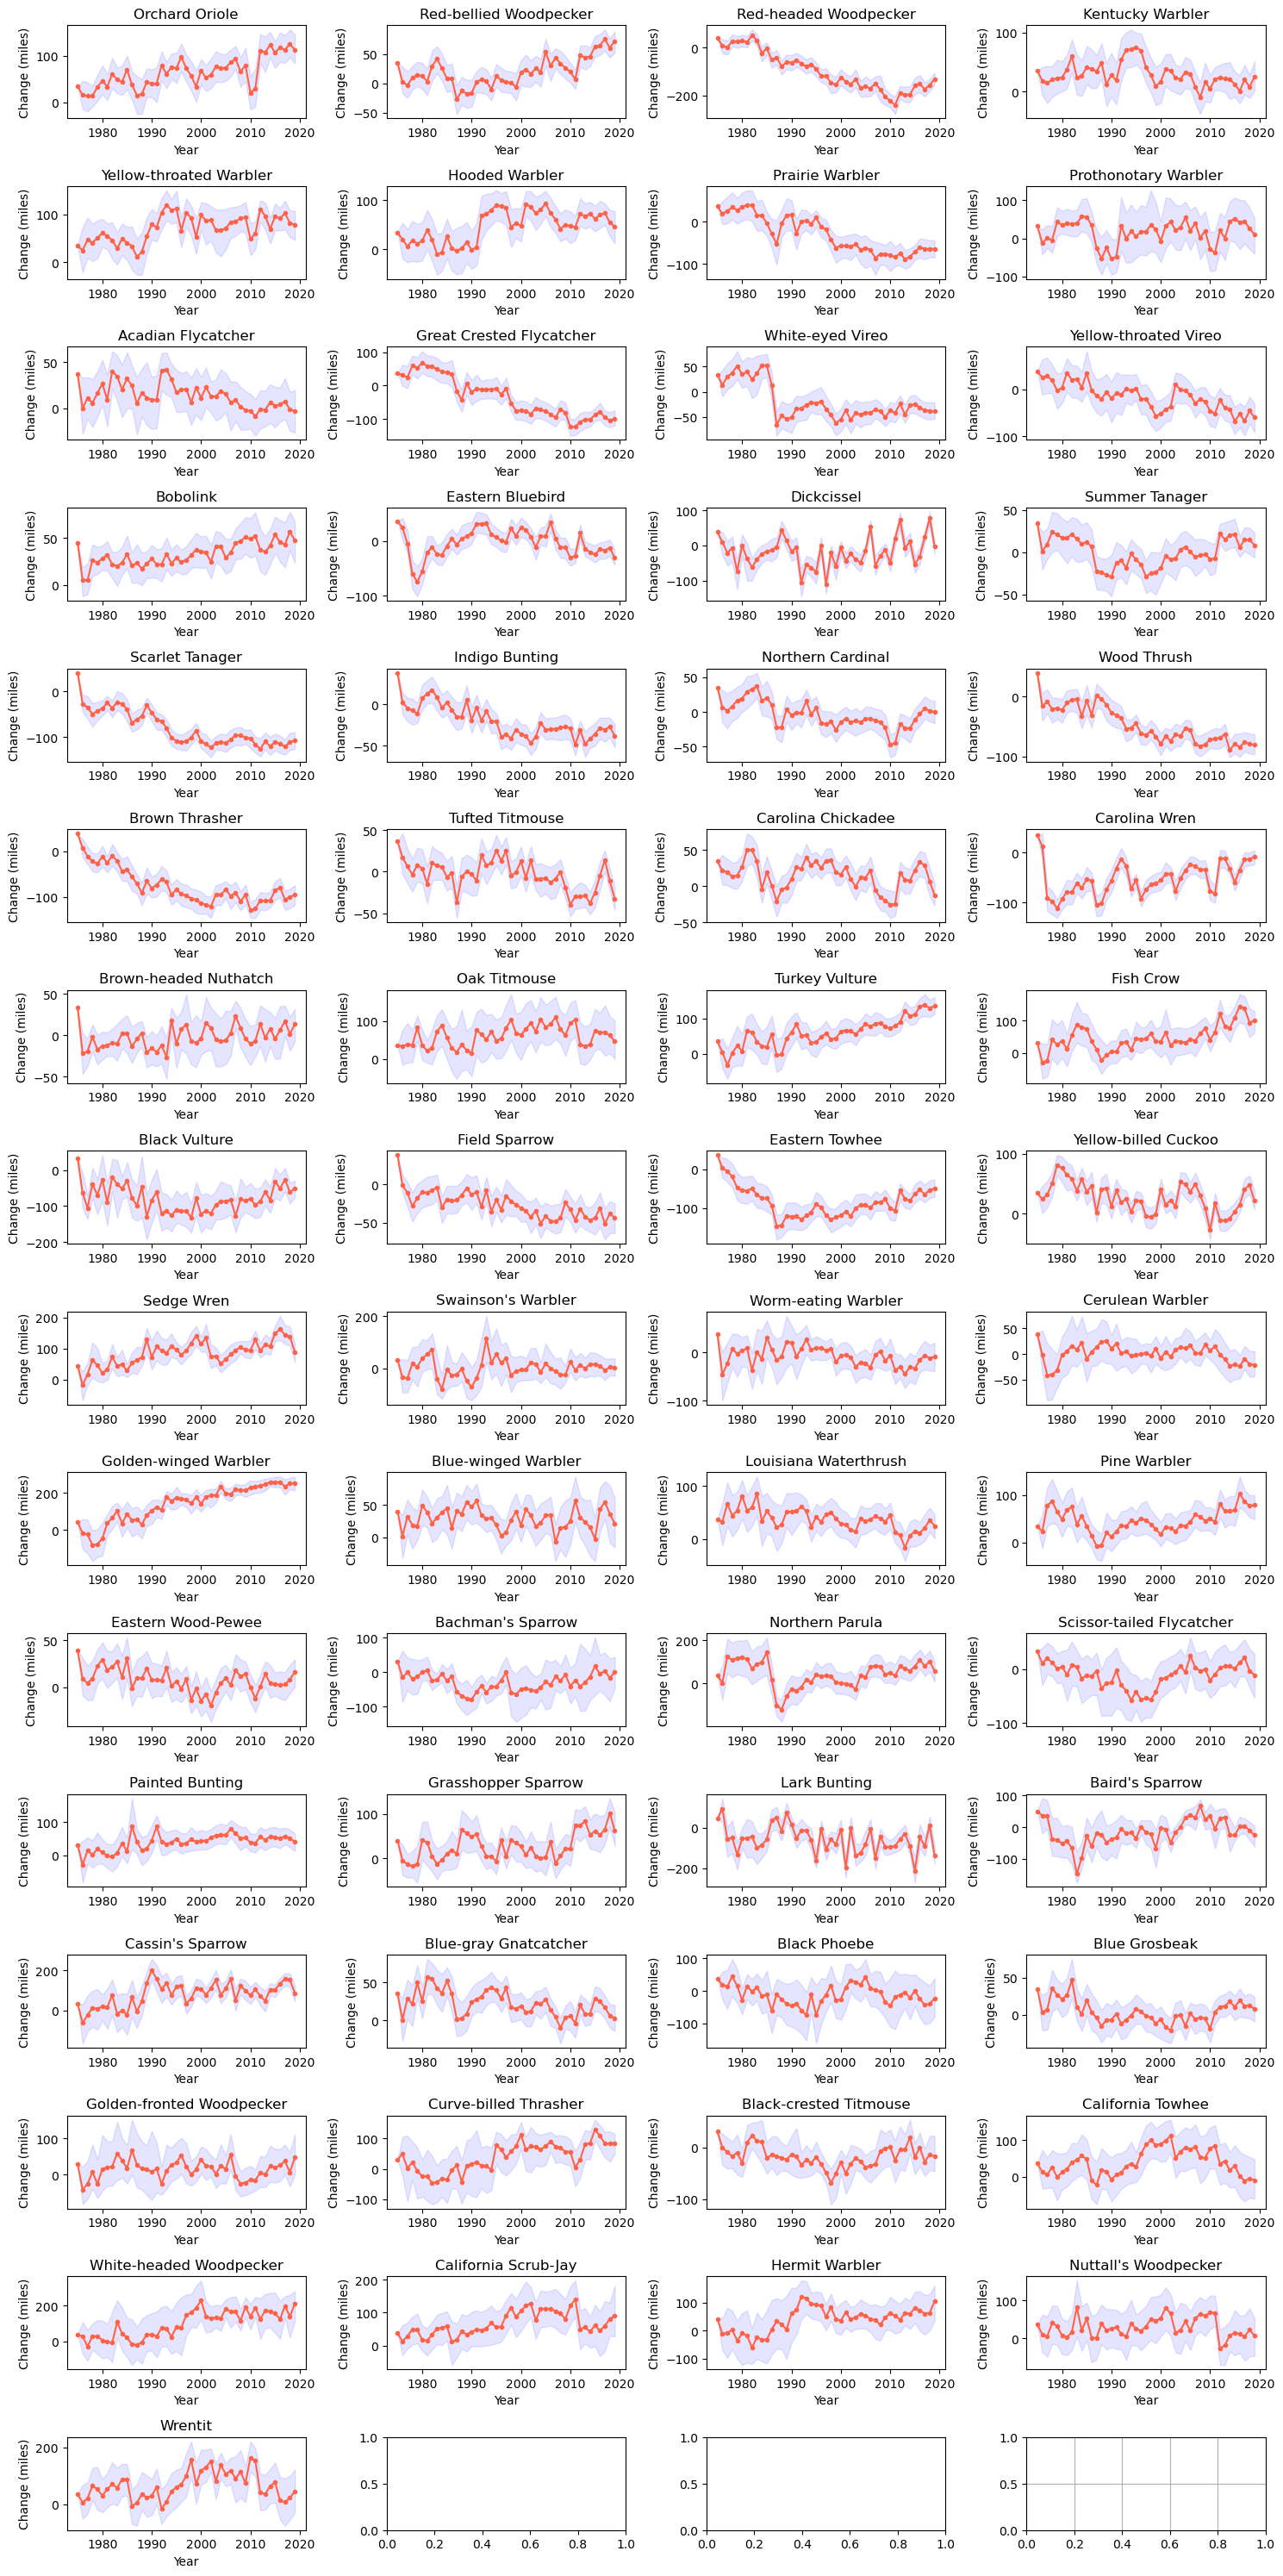

In [216]:
"""Plot each year's weighted mean latitude relative to 1975 for each species"""
fig,axs = plt.subplots(nrows = 16, ncols = 4, figsize = (15,30))
for species, axs in zip(species_means.common_name.unique(), axs.ravel()):
    df = species_means.query('common_name == @species')
    axs.plot('year',
             'mean',
              data = df,
              color = 'tomato',
              marker = '.')
    axs.fill_between(x = df['year'],
                    y1 = df['conf_int_2.5'],
                    y2 = df['conf_int_97.5'],
                    alpha = 0.1,
                    color = 'b')
    axs.set_title(f"{df.common_name[1]}")
    axs.set_ylabel('Change (miles)', size = 10)
    axs.set_xlabel('Year', size = 10)
plt.tight_layout()    
plt.grid();

In [245]:
northward_shift = ['Wrentit',
                  'Hermit Warbler',
                  'California Scrub-Jay',
                  'White-headed Woodpecker',
                  'Black-crested Titmouse',
                  'Curve-billed Thrasher',
                  'Black Phoebe',
                  "Baird's Sparrow",
                  'Painted Bunting',
                  'Scissor-tailed Flycatcher',
                  'Northern Parula',
                  'Golden-winged Warbler',
                  "Bachman's Sparrow",
                  'Eastern Towhee',
                  'Black Vulture',
                  'Fish Crow',
                  'Red-bellied Woodpecker',
                  'Orchard Oriole',
                  'California Towhee',
                  'Pine Warbler',
                  'Oak Titmouse',
                  'Eastern Bluebird',
                  'Bobolink']
means_increased_grouped = species_means[species_means['common_name'].isin(northward_shift)].groupby(by = 'year').agg(np.mean)
means_static_grouped = species_means[~species_means['common_name'].isin(northward_shift)].groupby(by = 'year').agg(np.mean)

Text(0.5, 0, 'Year')

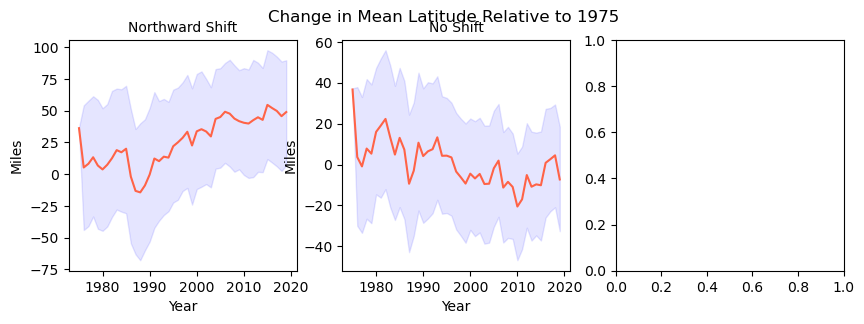

In [1240]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (10,3))
plt.suptitle("Change in Mean Latitude Relative to 1975")
axs[0].plot(means_increased_grouped.index,
             'mean',
              data = means_increased_grouped,
              color = 'tomato')
axs[0].fill_between(x = means_increased_grouped.index,
                y1 = means_increased_grouped['conf_int_2.5'],
                y2 = means_increased_grouped['conf_int_97.5'],
                alpha = 0.1,
                color = 'b')
axs[0].set_title("Northward Shift", size = 10)
axs[0].set_ylabel('Miles', size = 10)
axs[0].set_xlabel('Year', size = 10)

axs[1].plot(means_static_grouped.index,
             'mean',
              data = means_static_grouped,
              color = 'tomato')
axs[1].fill_between(x = means_static_grouped.index,
                y1 = means_static_grouped['conf_int_2.5'],
                y2 = means_static_grouped['conf_int_97.5'],
                alpha = 0.1,
                color = 'b')
axs[1].set_title("No Shift", size = 10)
axs[1].set_ylabel('Miles', size = 10)
axs[1].set_xlabel('Year', size = 10)



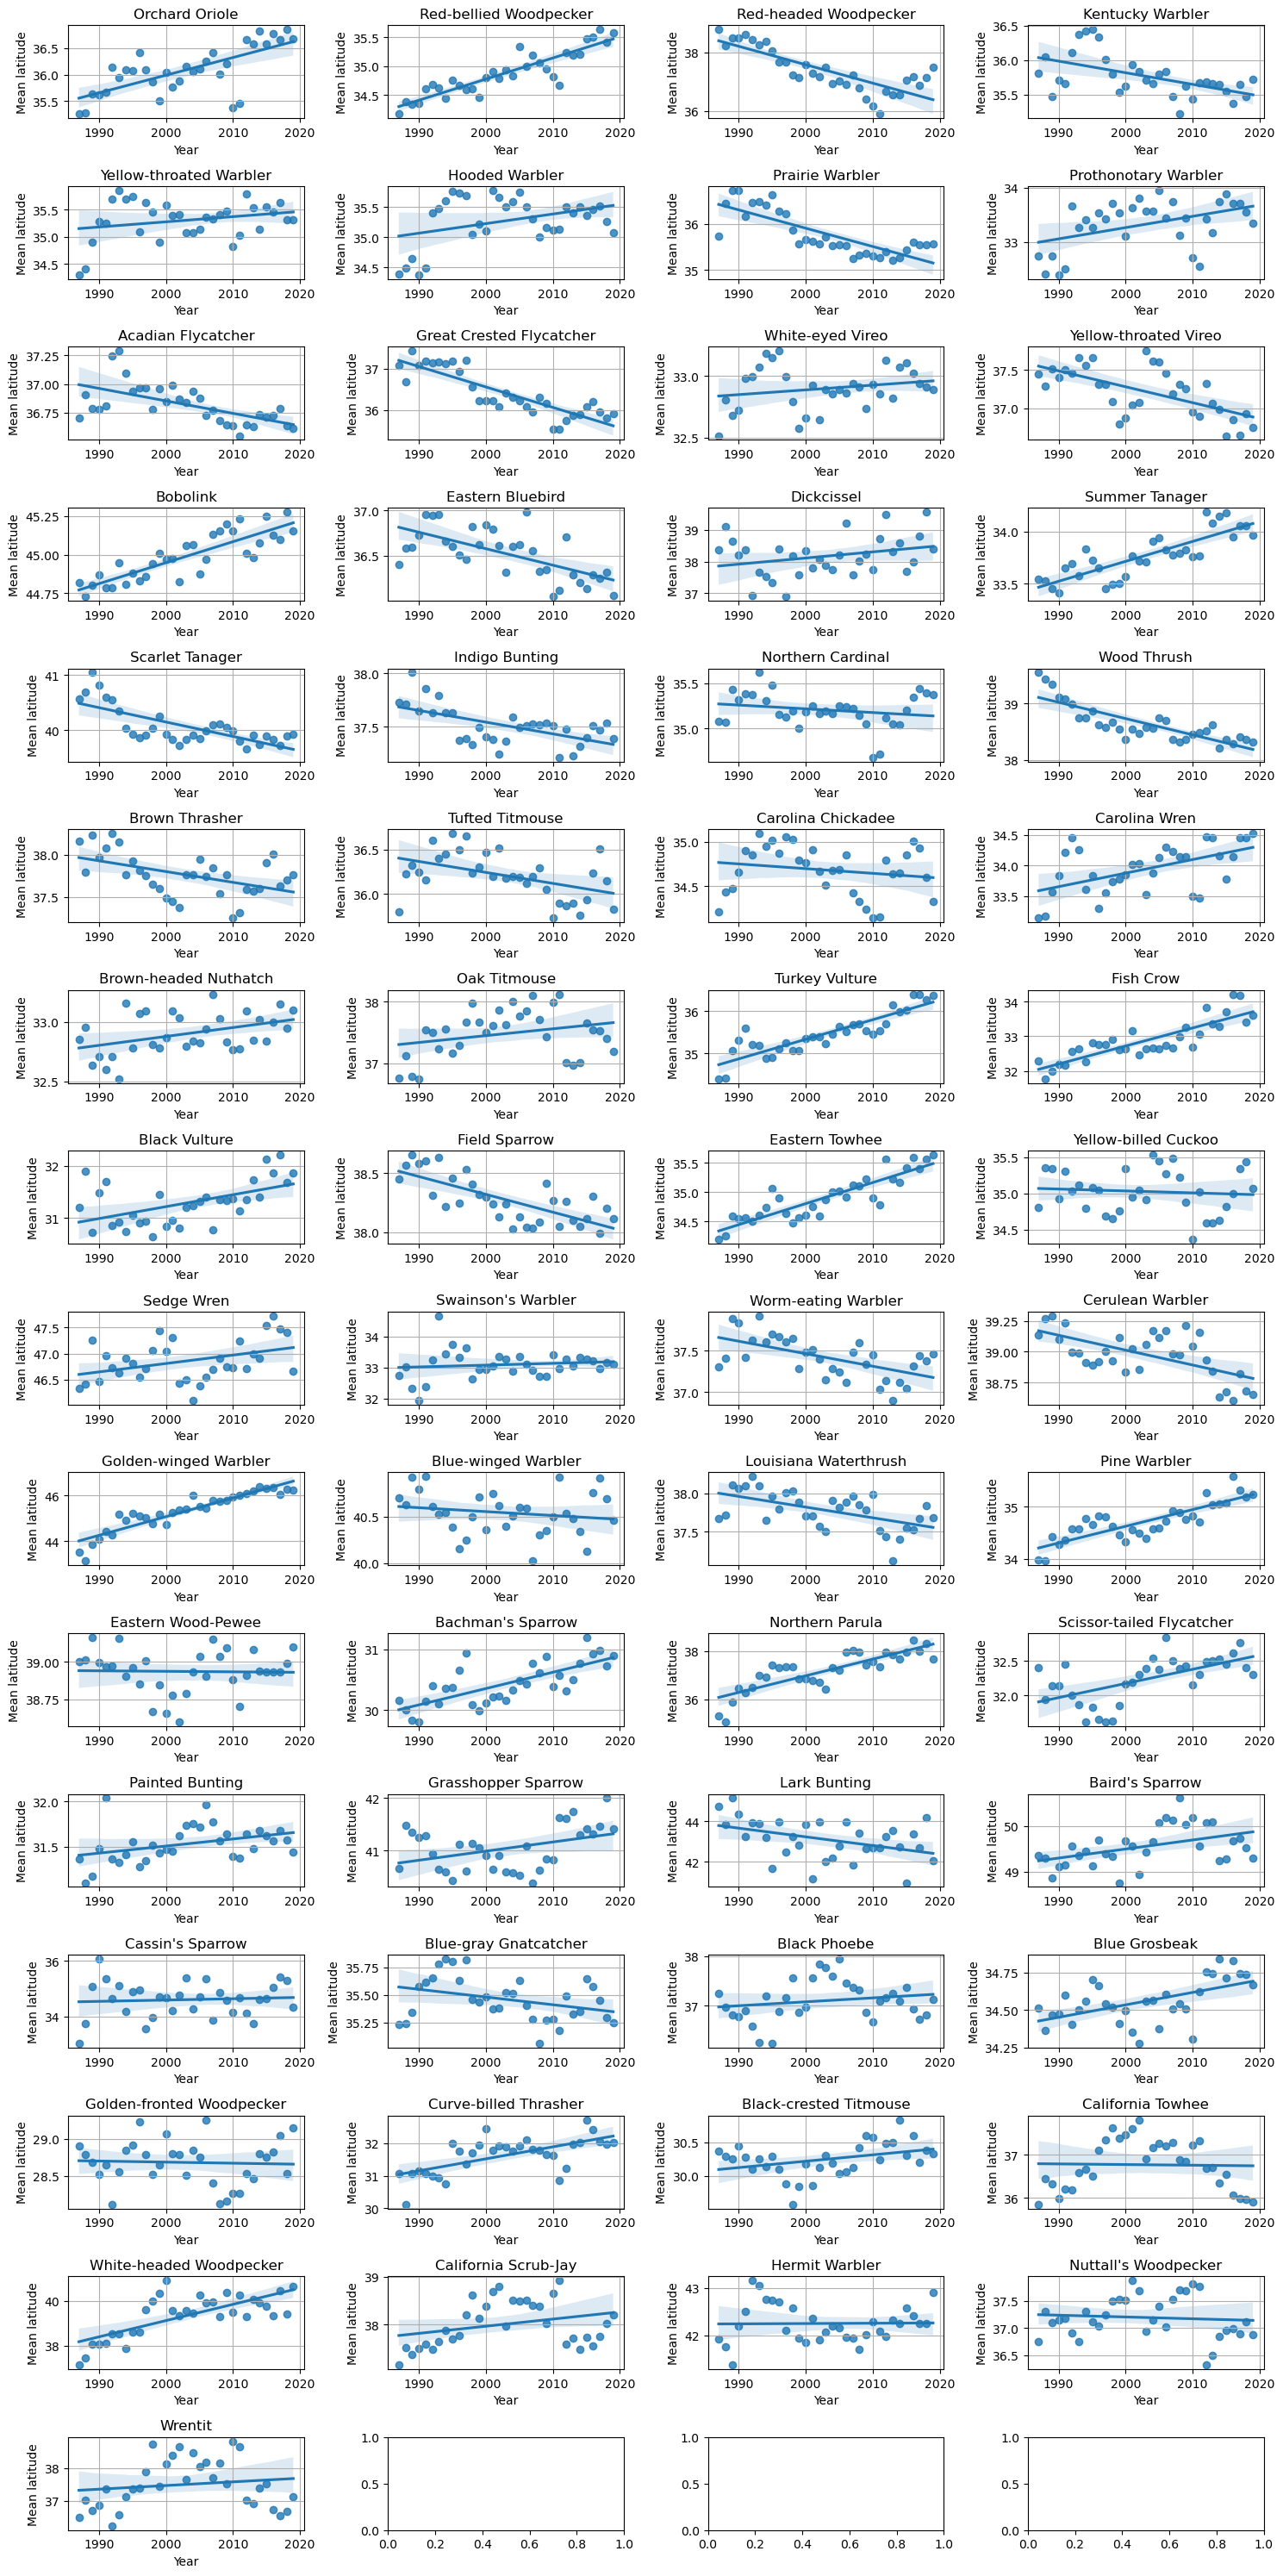

In [632]:
"""Plot weighted mean latitude over time for each species in species_list"""

fig,axs = plt.subplots(nrows = 16, ncols = 4, figsize = (15,30))
for species, axs in zip(species_list, axs.ravel()):
    df = range_centroid(df = us_canada_obs,
                      species = species,
                      values = 'latitude',
                      yr = 1987,
                      end_yr = 2019,
                      func = weighted_avg,
                      weights = 'speciestotal')

    sns.regplot(x = 'year',
             y = 'mean',
              data = df,
               ax = axs)
    axs.set_title(f"{species}")
    axs.set_ylabel('Mean latitude', size = 10)
    axs.set_xlabel('Year', size = 10)
    axs.grid()
plt.tight_layout();

In [243]:
"""Analysis of dynamics of northern/southern edge of ranges"""

northern_southern_edges = pd.DataFrame(columns = ['common_name',
                                                  'year',
                                                  'northern_edge',
                                                  'southern_edge'])
years = [i for i in  range(1987,2019+1)]
for species in species_list:
    for yr in years:
        northern_southern_edges.loc[len(northern_southern_edges.index),'common_name'] = species
        northern_southern_edges.loc[len(northern_southern_edges.index)-1,'year'] = yr
        southern, northern = np.percentile(us_canada_obs.query("""year == @yr & common_name == @species""")['latitude'],q = [2.5,97.5])
        northern_southern_edges.loc[len(northern_southern_edges.index)-1,'northern_edge'] = northern
        northern_southern_edges.loc[len(northern_southern_edges.index)-1,'southern_edge'] = southern
    print(species)

Orchard Oriole
Red-bellied Woodpecker
Red-headed Woodpecker
Kentucky Warbler
Yellow-throated Warbler
Hooded Warbler
Prairie Warbler
Prothonotary Warbler
Acadian Flycatcher
Great Crested Flycatcher
White-eyed Vireo
Yellow-throated Vireo
Bobolink
Eastern Bluebird
Dickcissel
Summer Tanager
Scarlet Tanager
Indigo Bunting
Northern Cardinal
Wood Thrush
Brown Thrasher
Tufted Titmouse
Carolina Chickadee
Carolina Wren
Brown-headed Nuthatch
Oak Titmouse
Turkey Vulture
Fish Crow
Black Vulture
Field Sparrow
Eastern Towhee
Yellow-billed Cuckoo
Sedge Wren
Swainson's Warbler
Worm-eating Warbler
Cerulean Warbler
Golden-winged Warbler
Blue-winged Warbler
Louisiana Waterthrush
Pine Warbler
Eastern Wood-Pewee
Bachman's Sparrow
Northern Parula
Scissor-tailed Flycatcher
Painted Bunting
Grasshopper Sparrow
Lark Bunting
Baird's Sparrow
Cassin's Sparrow
Blue-gray Gnatcatcher
Black Phoebe
Blue Grosbeak
Golden-fronted Woodpecker
Curve-billed Thrasher
Black-crested Titmouse
California Towhee
White-headed Woodpec

In [335]:
northern_southern_edges[['northern_edge','southern_edge']] = northern_southern_edges[['northern_edge','southern_edge']].astype(float)
northern_southern_edges['year'] = northern_southern_edges['year'].astype(int)

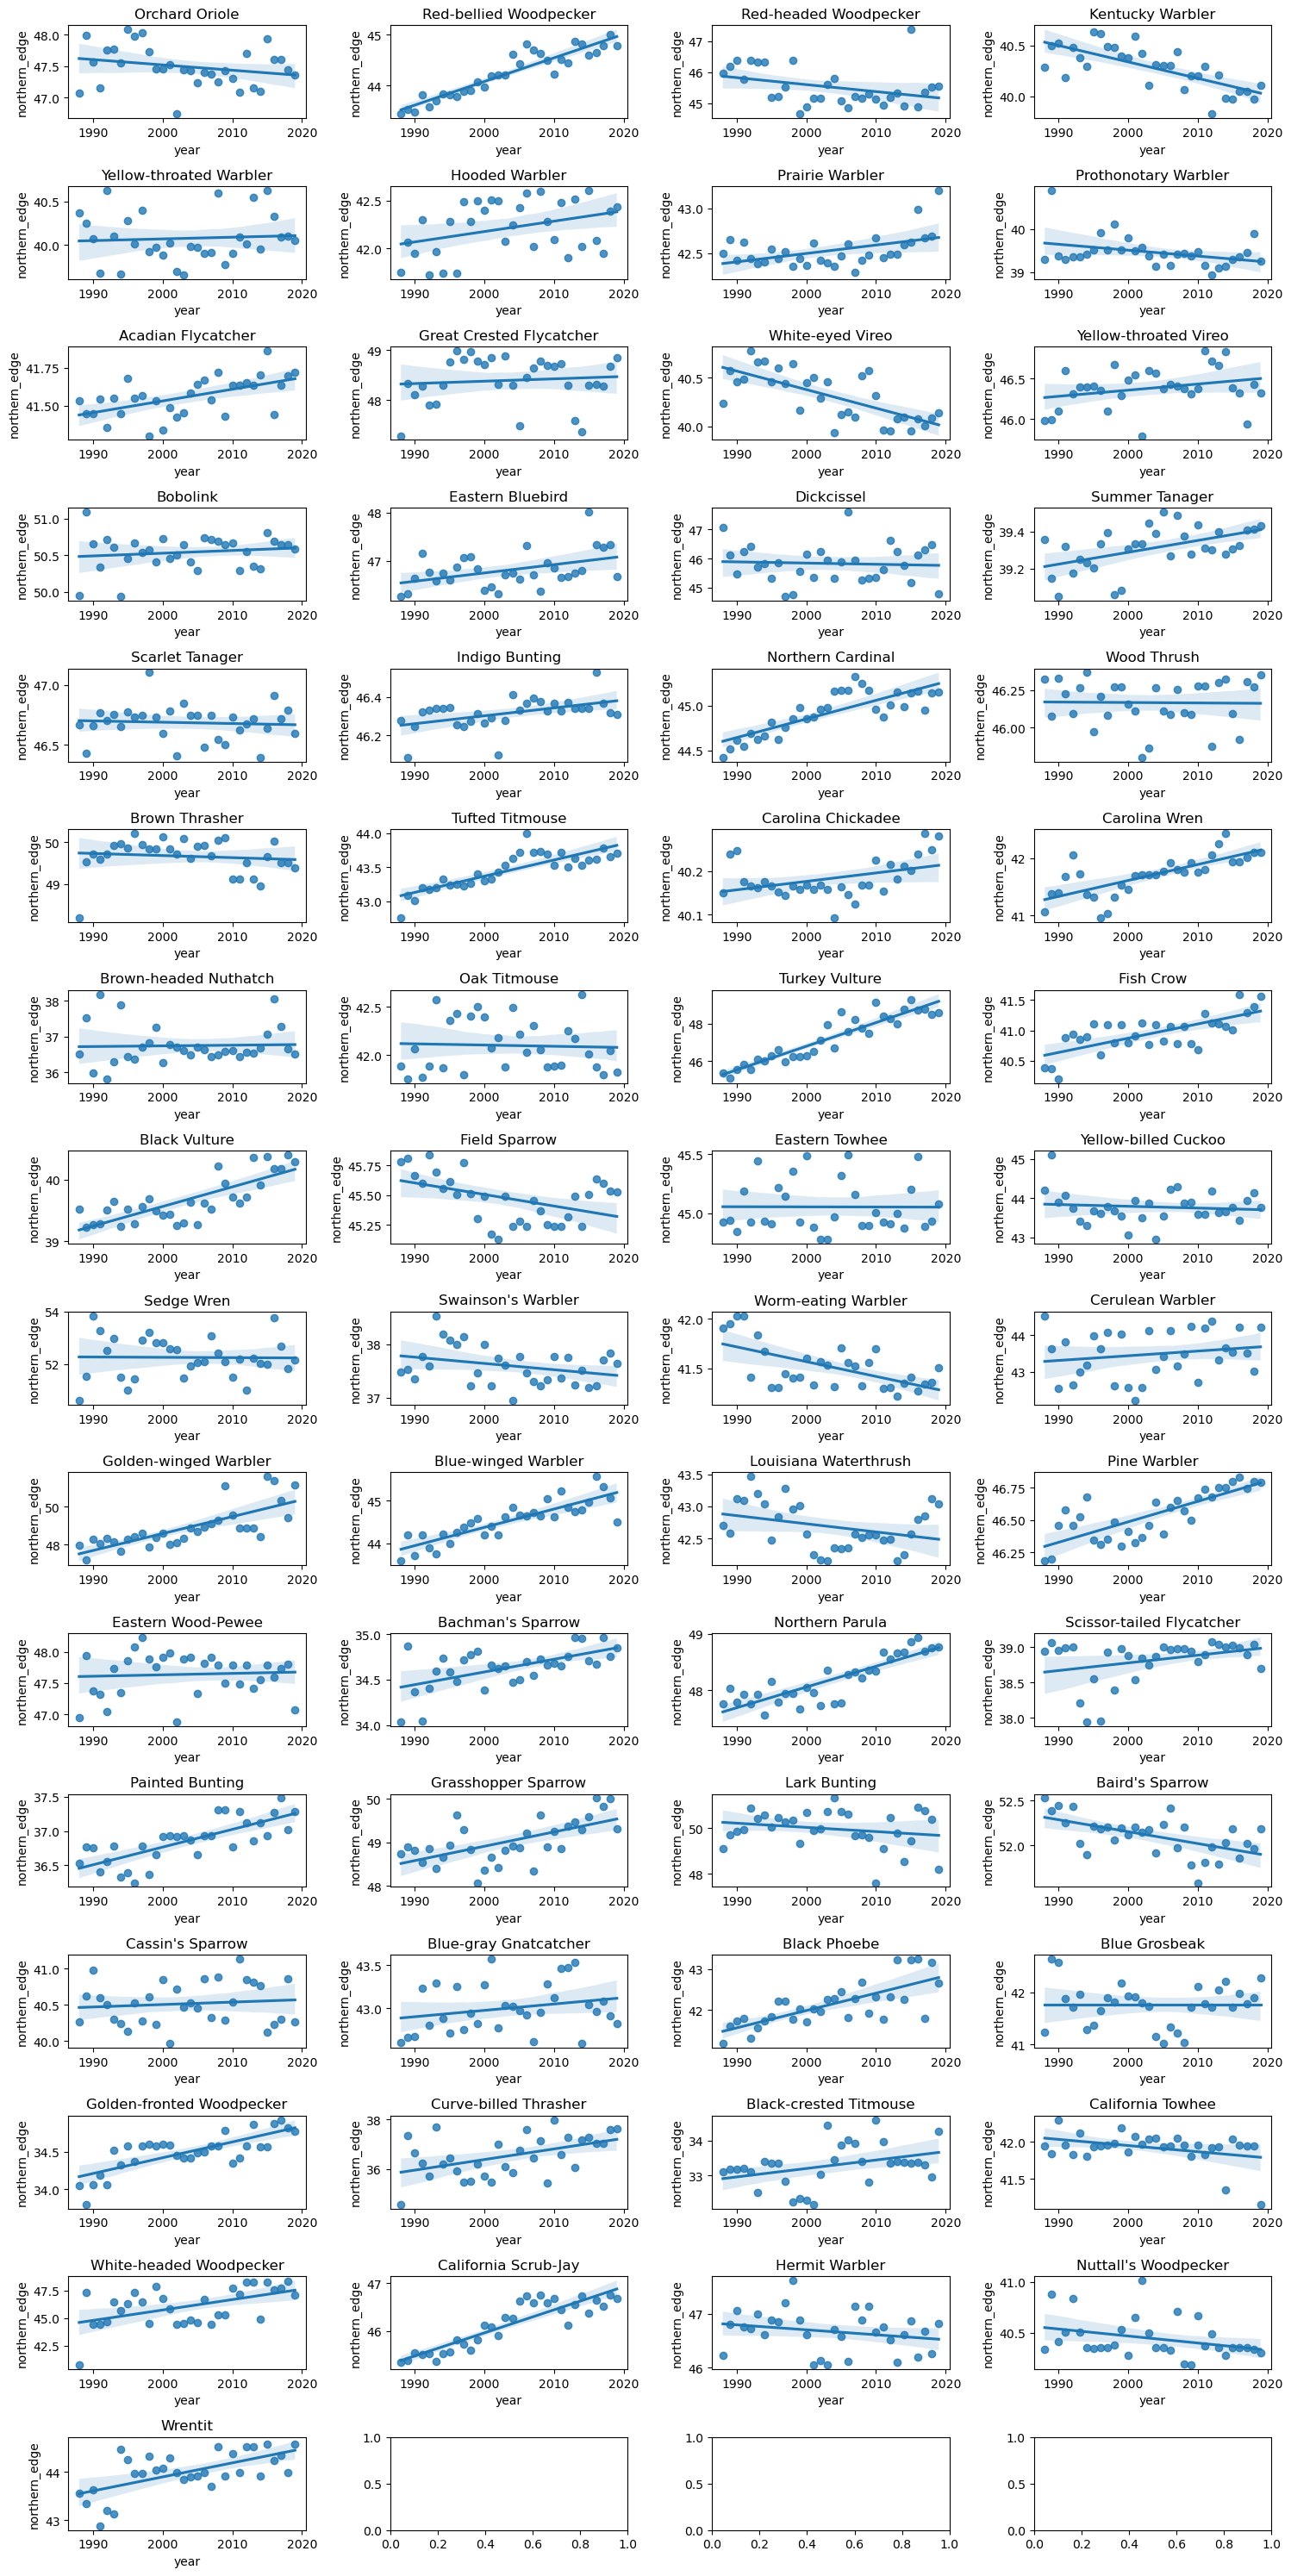

In [254]:
"""Regress northern edge on year"""

fig,axs = plt.subplots(nrows = 16, ncols = 4, figsize = (15,30))
for species, axs in zip(species_list, axs.ravel()):
    sns.regplot(data = northern_southern_edges.query('common_name == @species & year >= 1988'),
               x = 'year',
               y = 'northern_edge',
               ax = axs)
    axs.set_title(f"{species}")
plt.tight_layout()

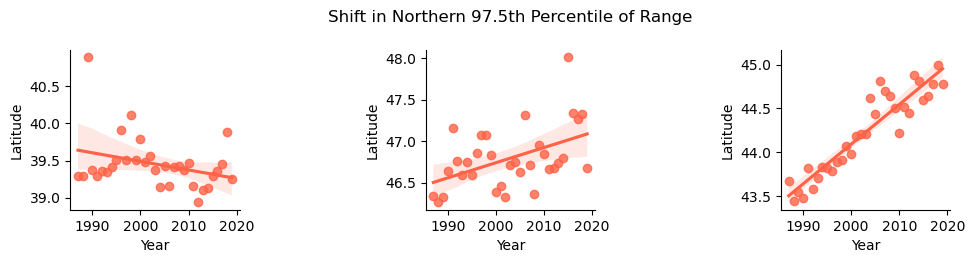

In [1216]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (11,2))

plt.suptitle('Shift in Northern 97.5th Percentile of Range', y = 1.1)

sns.regplot(data = northern_southern_edges.query('common_name == "Prothonotary Warbler" & year >= 1987'),
               x = 'year',
               y = 'northern_edge',
           color = 'tomato',
           ax = axs[0])
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Latitude')
sns.despine()
#plt.xlabel('Year');

sns.regplot(data = northern_southern_edges.query('common_name == "Eastern Bluebird" & year >= 1987'),
               x = 'year',
               y = 'northern_edge',
           color = 'tomato',
           ax = axs[1])
axs[1].set_xlabel('Year')
axs[1].set_ylabel('Latitude')
sns.despine()
plt.xlabel('Year');

sns.regplot(data = northern_southern_edges.query('common_name == "Red-bellied Woodpecker" & year >= 1987'),
               x = 'year',
               y = 'northern_edge',
           color = 'tomato',
           ax = axs[2])
axs[2].set_ylabel('Latitude')
sns.despine()
axs[2].set_xlabel('Year')

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=1.1,
                    hspace=0.4)


In [1118]:
"""Regress year on mean latitude and latitude of northern edge"""

species_summary = pd.DataFrame(columns = ['common_name',
                                          'coef_mean_lat',
                                          'coef_mean_lat_p',
                                          'coef_northern_lat',
                                          'coef_northern_lat_p'])
for species in species_list:
    w_avg =  range_centroid(df = us_canada_obs,
                            species = species,
                            values = 'latitude',
                            yr = 1987,
                            end_yr = 2019,
                            func = weighted_avg,
                            weights = 'speciestotal')
    # mean latitude
    model_w_avg = smf.ols(formula='mean ~ year', data = w_avg).fit()
    species_summary.loc[len(species_summary),'common_name'] = species
    species_summary.loc[len(species_summary)-1,'coef_mean_lat'] = model_w_avg.params[1]
    species_summary.loc[len(species_summary)-1,'coef_mean_lat_p'] = model_w_avg.pvalues[1]
    
    #northern edge
    model_north_edge = smf.ols(formula='northern_edge ~ year', data = northern_southern_edges.query('common_name == @species')).fit()
    species_summary.loc[len(species_summary)-1,'coef_northern_lat'] = model_north_edge.params[1]
    species_summary.loc[len(species_summary)-1,'coef_northern_lat_p'] = model_north_edge.pvalues[1]

In [1119]:
"""Merge species_summary and species_names to get scientific names"""

np.setdiff1d(species_summary['common_name'].unique(),
             species_names['common_name'].unique())


array([], dtype=object)

In [1120]:
"""Merge species_summary and species_names on common_name columns"""
species_summary = species_summary.merge(right = species_names[['common_name','scientific_name']], 
                                        how = 'left',
                                        on = 'common_name') 

In [1122]:
species_summary['mean_shift'] = np.where(species_summary['coef_mean_lat'] > 0,
                                        'Shift',
                                        'No Shift')

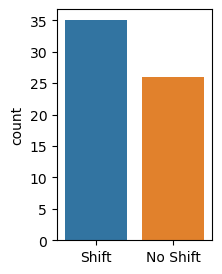

In [1123]:
fig, axs = plt.subplots(figsize = (2,3))
sns.countplot(data = species_summary,
              x = 'mean_shift')
axs.set_xlabel('');

In [1124]:
species_summary = species_summary[['common_name',
                                   'scientific_name',
                                   'coef_mean_lat',
                                   'coef_mean_lat_p',
                                   'coef_northern_lat',
                                   'coef_northern_lat_p'
                                  ]]

In [1125]:
species_summary.scientific_name = species_summary.scientific_name.str.rstrip()

In [1126]:
species_biology = pd.read_csv('/Users/jnl741/Documents/Data_for_projects/Bird_data/Avonet/TraitData/AVONET1_BirdLife.csv')
species_biology.head()

Sequence               Species1       Family1           Order1  \
0    3103.0  Accipiter albogularis  Accipitridae  Accipitriformes   
1    3090.0       Accipiter badius  Accipitridae  Accipitriformes   
2    3125.0      Accipiter bicolor  Accipitridae  Accipitriformes   
3    3116.0   Accipiter brachyurus  Accipitridae  Accipitriformes   
4    3092.0     Accipiter brevipes  Accipitridae  Accipitriformes   

        Avibase.ID1  Total.individuals  Female  Male  Unknown  \
0  AVIBASE-BBB59880                  5       2     0        3   
1  AVIBASE-1A0ECB6E                 10       4     6        0   
2  AVIBASE-ADBE44E1                 11       4     5        2   
3  AVIBASE-68BF920B                  4       4     0        0   
4  AVIBASE-8492E4B7                  8       4     4        0   

   Complete.measures  Beak.Length_Culmen  Beak.Length_Nares  Beak.Width  \
0                  4                27.7               17.8        10.6   
1                  8                20.6               12.1         8.8   
2                  8                25.0               13.7         8.6   
3                  3                22.5               14.0         8.9   
4                  4                21.1               12.1         8.7   

   Beak.Depth  Tarsus.Length  Wing.Length  Kipps.Distance  Secondary1  \
0        14.7           62.0        235.2            81.8       159.5   
1        11.6           43.0        186.7            62.5       127.4   
2        12.7           58.1        229.6            56.6       174.8   
3        11.9           61.2        202.2            64.1       138.1   
4        11.1           46.4        217.6            87.8       129.9   

   Hand-Wing.Index  Tail.Length   Mass Mass.Source Mass.Refs.Other Inference  \
0             33.9        169.0  248.8     Dunning             NaN        NO   
1             32.9        140.6  131.2     Dunning             NaN        NO   
2             24.6        186.3  287.5     Dunning             NaN        NO   
3             31.7        140.8  142.0     Dunning             NaN        NO   
4             40.2        153.5  186.5     Dunning             NaN        NO   

  Traits.inferred Reference.species    Habitat  Habitat.Density  Migration  \
0             NaN               NaN     Forest                1        2.0   
1             NaN               NaN  Shrubland                2        3.0   
2             NaN               NaN   Woodland                2        2.0   
3             NaN               NaN     Forest                1        2.0   
4             NaN               NaN     Forest                1        3.0   

  Trophic.Level Trophic.Niche Primary.Lifestyle  Min.Latitude  Max.Latitude  \
0     Carnivore     Vertivore       Insessorial        -11.73         -4.02   
1     Carnivore     Vertivore       Insessorial        -29.47         46.39   
2     Carnivore     Vertivore        Generalist        -55.72         23.73   
3     Carnivore     Vertivore       Insessorial         -6.31         -4.08   
4     Carnivore     Vertivore        Generalist         31.19         55.86   

   Centroid.Latitude  Centroid.Longitude   Range.Size  
0              -8.15              158.49     37461.21  
1               8.23               44.98  22374973.00  
2             -10.10              -59.96  14309701.27  
3              -5.45              150.68     35580.71  
4              45.24               45.33   2936751.80

In [1127]:
species_biology.columns = species_biology.columns.str.lower()
species_biology.rename(columns = {'species1' : 'scientific_name'}, inplace = True)

In [1128]:
species_summary.head()

common_name             scientific_name coef_mean_lat  \
0           Orchard Oriole             Icterus spurius      0.033245   
1   Red-bellied Woodpecker        Melanerpes carolinus      0.036726   
2    Red-headed Woodpecker  Melanerpes erythrocephalus      -0.06274   
3         Kentucky Warbler          Geothlypis formosa     -0.016856   
4  Yellow-throated Warbler          Setophaga dominica      0.009569   

  coef_mean_lat_p coef_northern_lat coef_northern_lat_p  
0        0.000006         -0.006851            0.237433  
1             0.0          0.045368                 0.0  
2             0.0          -0.02295             0.03764  
3        0.001291         -0.013715            0.000081  
4         0.15187          0.004322            0.415471

In [1129]:
species_biology.columns  = clean_columns(species_biology)

/var/folders/v9/483tmlvj28ldt2s2wvphywvxd4j0g_/T/ipykernel_93052/3254622372.py:1: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.



In [1130]:
"""Check that there is agreement between 'scientific_name' columns of species_biology and species_summary dfs before
merging"""

np.setdiff1d(species_summary['scientific_name'].unique(),
             species_biology['scientific_name'].unique())

array(['Centronyx bairdii', 'Picoides albolarvatus'], dtype=object)

In [1131]:
species_biology[species_biology['scientific_name'].str.contains('Leuconotopicus albolarvatus')]

sequence              scientific_name  family1      order1  \
9839    3979.0  Leuconotopicus albolarvatus  Picidae  Piciformes   

           avibase_id1  total_individuals  female  male  unknown  \
9839  AVIBASE-6C74415D                  5       2     2        1   

      complete_measures  beak_length_culmen  beak_length_nares  beak_width  \
9839                  4                26.0               20.5         7.3   

      beak_depth  tarsus_length  wing_length  kipps_distance  secondary1  \
9839         7.2           20.4        127.0            33.1        95.3   

      hand-wing_index  tail_length  mass mass_source mass_refs_other  \
9839             25.8         90.0  61.1     Dunning             NaN   

     inference traits_inferred reference_species habitat  habitat_density  \
9839        NO             NaN               NaN  Forest                2   

      migration trophic_level trophic_niche primary_lifestyle  min_latitude  \
9839        1.0     Carnivore   Invertivore       Insessorial         33.08   

      max_latitude  centroid_latitude  centroid_longitude  range_size  
9839         50.01              42.45             -119.71   499656.93

In [1132]:
species_summary.loc[species_summary['scientific_name'] == 'Picoides albolarvatus','scientific_name'] = 'Leuconotopicus albolarvatus'

In [1133]:
species_names.loc[species_names['scientific_name'] == 'Setophaga  citrina','scientific_name'] = 'Setophaga citrina'

In [1134]:
"""Merge species_summary and species_biology. Use a left join to include Baird's Sparrow, whose details can 
be filled in afterwards."""
species_summary = species_summary.merge(right = species_biology[['scientific_name',
                                                                'beak_width',
                                                                'beak_depth',
                                                                "kipps_distance",
                                                                'hand-wing_index',
                                                                'tail_length',
                                                                'mass',
                                                                'habitat',
                                                                'migration',
                                                                'trophic_level',
                                                                'trophic_niche',
                                                                'primary_lifestyle',
                                                                'range_size',
                                                                'centroid_latitude']],
                                       on = 'scientific_name',
                                       how = 'left')

In [1135]:
species_summary.columns = species_summary.columns.str.replace("-","_")

In [1136]:
species_summary.shape

(61, 19)

In [1137]:
species_names['scientific_name'] = species_names['scientific_name'].str.rstrip()

In [1138]:
species_summary['migration'] = species_summary['migration'].map({1:'Resident', 2:'Short_Distance',3:'Long_Distance'})

In [1139]:
"""AVONET classifies pine warbler and painted bunting as long-distance migrants, but other sources classify them
as short-distance migrants. Both species maintain some small presence during the winter, as well. They would be
more accurately described as short-distance migrants."""

species_summary.loc[species_summary['common_name'].isin(["Pine Warbler",'Painted Bunting']),'migration'] = 'Short_Distance'

Text(0.5, 1.0, 'Northern Range Expansion')

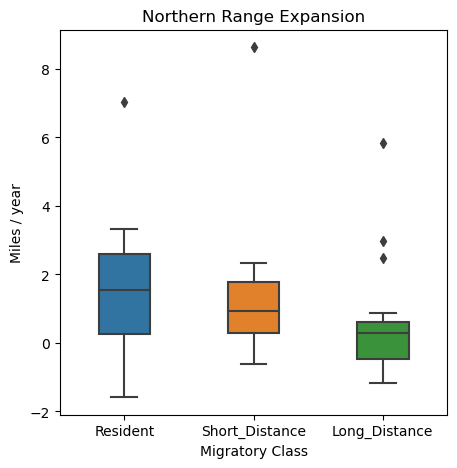

In [1141]:
"""Relationship between migration behavior and northern range expansion"""
fig, axs = plt.subplots(figsize = (5,5))
sns.boxplot(data = species_summary,
           x = 'migration',
           y = species_summary['coef_northern_lat']*69,
           order = ['Resident','Short_Distance','Long_Distance'],
           width = 0.4)
plt.ylabel("Miles / year")
plt.xlabel('Migratory Class')
plt.title("Northern Range Expansion")

In [1144]:
species_summary.dtypes

common_name             object
scientific_name         object
coef_mean_lat           object
coef_mean_lat_p         object
coef_northern_lat       object
coef_northern_lat_p     object
beak_width             float64
beak_depth             float64
kipps_distance         float64
hand_wing_index        float64
tail_length            float64
mass                   float64
habitat                 object
migration               object
trophic_level           object
trophic_niche           object
primary_lifestyle       object
range_size             float64
centroid_latitude      float64
dtype: object

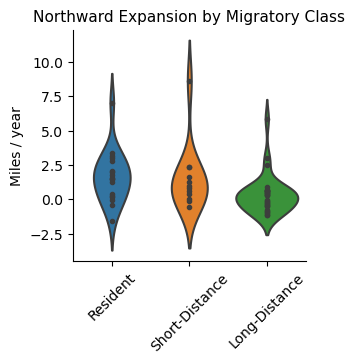

In [1155]:
fig, axs = plt.subplots(figsize = (3,3))
sns.violinplot(data = species_summary,
           x = 'migration',
           y = species_summary['coef_northern_lat']*69,
           order = ['Resident','Short_Distance','Long_Distance'],
              inner = 'points')
plt.ylabel("Miles / year")
plt.xlabel('')
axs.set_xticklabels(['Resident','Short-Distance','Long-Distance'])
plt.title("Northward Expansion by Migratory Class", size = 11)
plt.xticks(rotation = 45)
sns.despine();

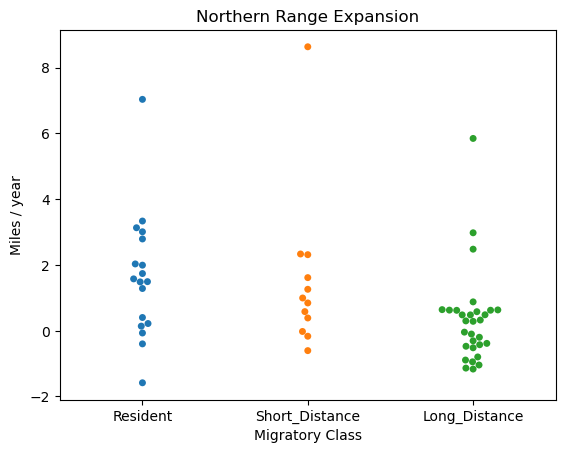

In [1160]:
sns.swarmplot(data = species_summary,
           x = 'migration',
           y = species_summary['coef_northern_lat']*69,
           order = ['Resident','Short_Distance','Long_Distance'])
plt.ylabel("Miles / year")
plt.xlabel('Migratory Class')
plt.title("Northern Range Expansion");

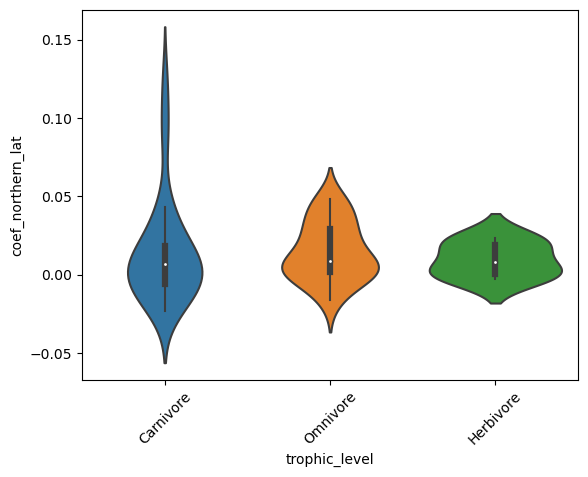

In [1168]:
sns.violinplot(data = species_summary,
           x = 'trophic_level',
           y = 'coef_northern_lat')
plt.xticks(rotation = 45);

In [1167]:
species_summary.loc[species_summary['common_name'] == 'Turkey Vulture', 'trophic_level'] = 'Carnivore'

In [1163]:
pd.crosstab(index = species_summary['migration'],
           columns = species_summary['trophic_level'],
           margins = True)

trophic_level   Carnivore  Herbivore  Omnivore  Scavenger  All
migration                                                     
Long_Distance          23          1         6          0   30
Resident                6          2        10          0   18
Short_Distance          3          3         5          1   12
All                    32          6        21          1   60

In [1187]:
"""Append centroid latitude and max latitude to species_summary"""

species_summary[['centroid_lat','max_lat']] = np.nan
for species in species_list:
    df = us_canada_obs.query('common_name == @species & year == 1987')
    centroid_lat = weighted_avg(df = df,
                          values = 'latitude',
                          weights = 'speciestotal')
    max_lat = max(df['latitude'])
    species_summary.loc[species_summary['common_name'] == species, 'centroid_lat'] = centroid_lat
    species_summary.loc[species_summary['common_name'] == species, 'max_lat'] = max_lat

In [1063]:
species_summary.loc[species_summary['common_name'] == 'Fish Crow','habitat'] = 'Human Modified'

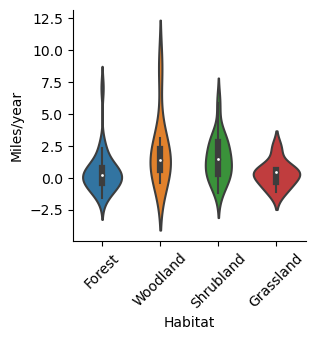

In [1204]:
fig, axs = plt.subplots(figsize = (3,3))
sns.violinplot(data = species_summary,
           x = 'habitat',
           y = species_summary['coef_northern_lat'] * 69,
              ax = axs)
plt.xticks(rotation = 45)
axs.set_xlabel('Habitat')
axs.set_ylabel('Miles/year')
sns.despine();

In [1173]:
pd.crosstab(index = species_summary['migration'],
           columns = species_summary['habitat'],
           margins = True)

habitat         Forest  Grassland  Shrubland  Woodland  All
migration                                                  
Long_Distance       18          4          6         2   30
Resident             5          0          9         4   18
Short_Distance       4          4          2         2   12
All                 27          8         17         8   60

In [1145]:
"""In order to increase statistical power, consolidate the habitat groups. The following species spend considerable
amounts of time in these habitats."""
species_summary.loc[species_summary['habitat'] == 'Rock','habitat'] = 'Shrubland'
species_summary.loc[species_summary['common_name'] == 'Scissor-tailed Flycatcher','habitat'] = 'Grassland'
species_summary.loc[species_summary['common_name'] == 'Black Vulture','habitat'] = 'Forest'
species_summary.loc[species_summary['common_name'] == 'Turkey Vulture','habitat'] = 'Woodland'
species_summary.loc[species_summary['common_name'] == 'Fish Crow','habitat'] = 'Shrubland'

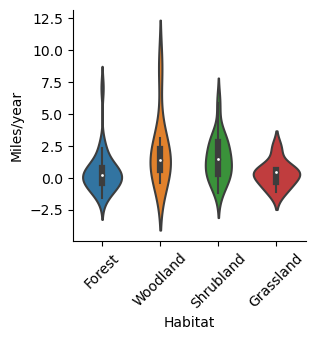

In [1241]:
fig, axs = plt.subplots(figsize = (3,3))
sns.violinplot(data = species_summary,
           x = 'habitat',
           y = species_summary['coef_northern_lat'] * 69,
              ax = axs)
plt.xticks(rotation = 45)
axs.set_xlabel('Habitat')
axs.set_ylabel('Miles/year')
sns.despine();

In [1150]:
species_summary[['coef_mean_lat','coef_northern_lat']] = species_summary[['coef_mean_lat','coef_northern_lat']].astype(float)

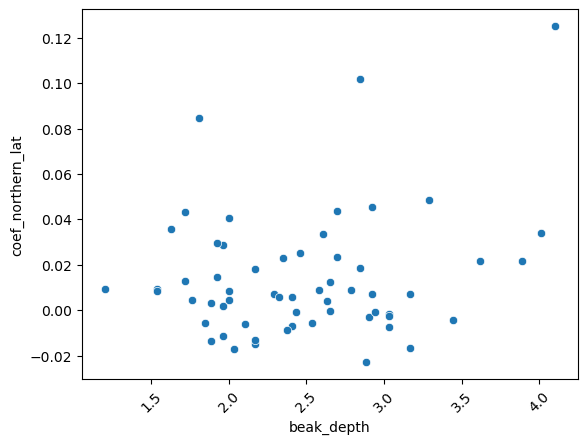

In [1072]:
sns.scatterplot(data = species_summary,
           x = np.log2(species_summary['beak_depth']),
           y = 'coef_northern_lat')
plt.xticks(rotation = 45);

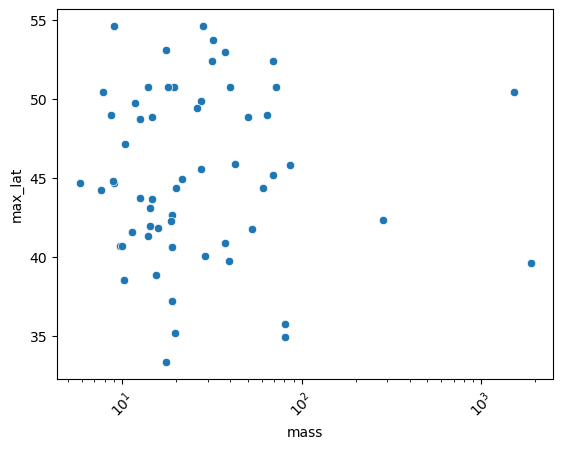

In [1086]:
fig, axs = plt.subplots()
sns.scatterplot(data = species_summary,
           x = species_summary['mass'],
           y = 'max_lat',
           ax = axs)
axs.set_xscale('log')
plt.xticks(rotation = 45);

<AxesSubplot:xlabel='range_size', ylabel='coef_northern_lat'>

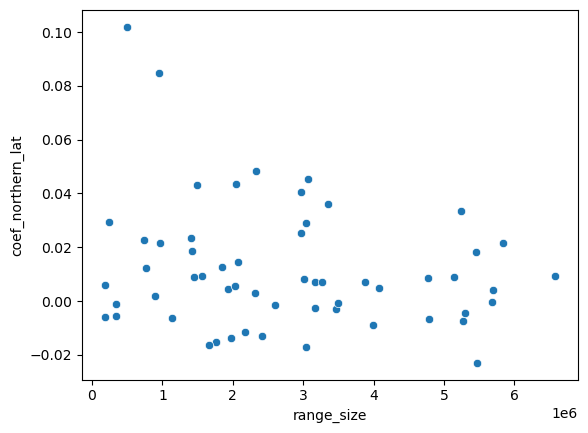

In [1075]:
sns.scatterplot(data = species_summary,
               x = species_summary.query('range_size < 2 * 10**7')['range_size'],
               y = species_summary.query('range_size < 2 * 10**7')['coef_northern_lat'])

<AxesSubplot:xlabel='migration', ylabel='max_lat'>

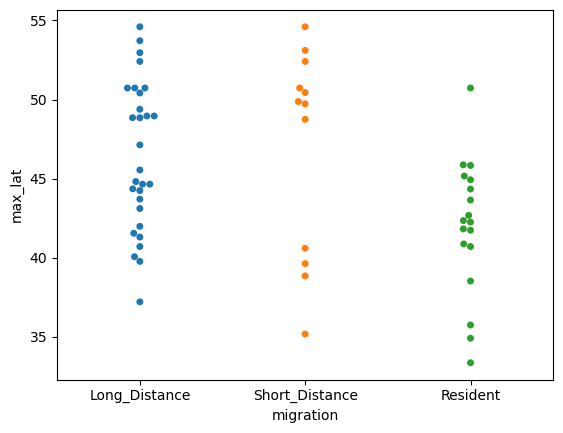

In [1076]:
sns.swarmplot(data = species_summary,
           x = 'migration',
           y = 'max_lat',
           order = ['Long_Distance','Short_Distance','Resident'])

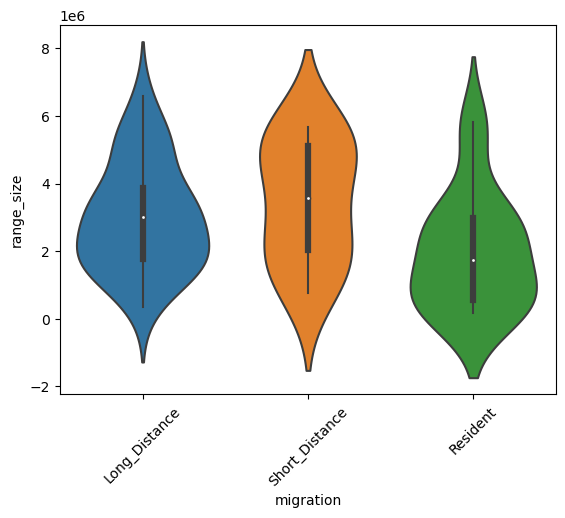

In [1077]:
fig, axs = plt.subplots()
sns.violinplot(data = species_summary,
           x = 'migration',
           y = species_summary.query('range_size < 2 * 10**7')['range_size'],
           order = ['Long_Distance','Short_Distance','Resident'],
             ax = axs),
plt.xticks(rotation = 45);


<AxesSubplot:xlabel='migration', ylabel='mass'>

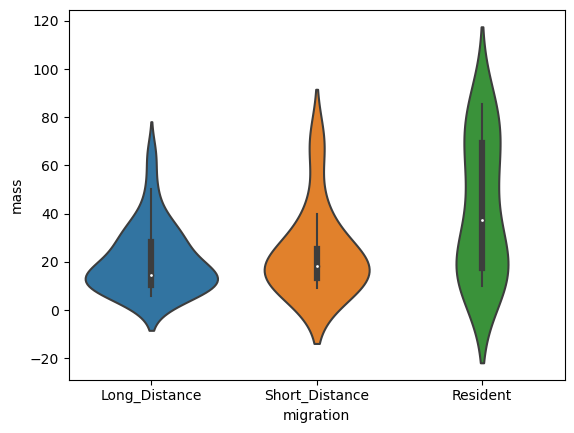

In [1029]:
sns.violinplot(data = species_summary,
           x = 'migration',
           y = species_summary.query('mass < 250')['mass'],
           order = ['Long_Distance','Short_Distance','Resident'])

<AxesSubplot:xlabel='migration', ylabel='beak_depth'>

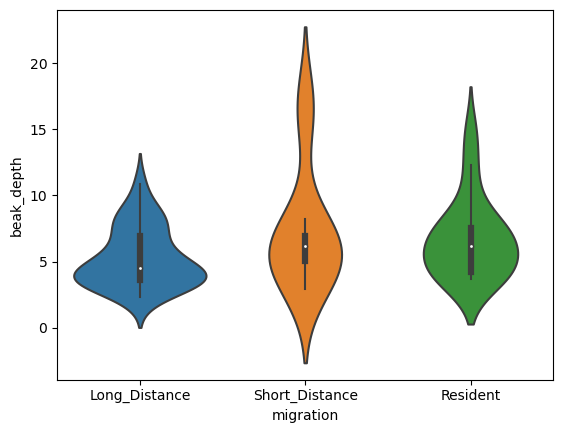

In [1030]:
sns.violinplot(data = species_summary,
           x = 'migration',
           y = 'beak_depth',
           order = ['Long_Distance','Short_Distance','Resident'])

<AxesSubplot:xlabel='migration', ylabel='hand_wing_index'>

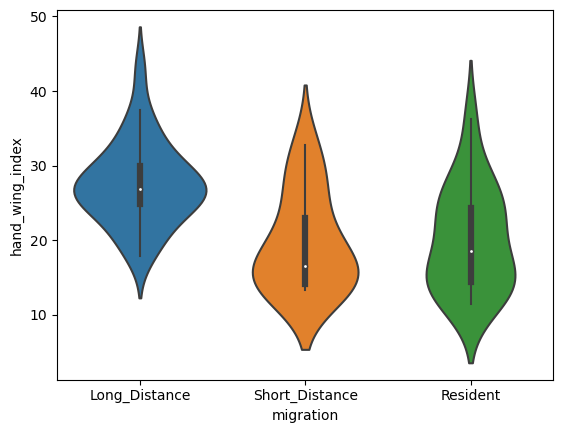

In [1024]:
sns.violinplot(data = species_summary,
           x = 'migration',
           y = 'hand_wing_index',
           order = ['Long_Distance','Short_Distance','Resident'])

In [1097]:
species_summary.head()

common_name             scientific_name  coef_mean_lat  \
0           Orchard Oriole             Icterus spurius       0.033245   
1   Red-bellied Woodpecker        Melanerpes carolinus       0.036726   
2    Red-headed Woodpecker  Melanerpes erythrocephalus      -0.062740   
3         Kentucky Warbler          Geothlypis formosa      -0.016856   
4  Yellow-throated Warbler          Setophaga dominica       0.009569   

  coef_mean_lat_p  coef_northern_lat coef_northern_lat_p  beak_width_x  \
0        0.000006          -0.006851            0.237433           4.4   
1             0.0           0.045368                 0.0           7.1   
2             0.0          -0.022950             0.03764           7.6   
3        0.001291          -0.013715            0.000081           3.5   
4         0.15187           0.004322            0.415471           3.0   

   beak_depth_x  kipps_distance_x  hand_wing_index  tail_length_x  mass_x  \
0           5.3              20.9             26.9           67.0    19.4   
1           7.6              35.5             28.2           76.8    69.5   
2           7.4              40.6             29.1           83.3    71.6   
3           3.7              16.6             24.9           48.1    14.0   
4           3.4              18.8             27.7           50.7     9.7   

  habitat_x    migration_x trophic_level_x trophic_niche_x  \
0    Forest  Long_Distance       Carnivore     Invertivore   
1  Woodland       Resident        Omnivore        Omnivore   
2    Forest       Resident       Carnivore     Invertivore   
3    Forest  Long_Distance       Carnivore     Invertivore   
4    Forest  Long_Distance       Carnivore     Invertivore   

  primary_lifestyle_x  range_size_x  centroid_latitude_x  centroid_lat  \
0         Insessorial      0.294985                36.74     35.258496   
1         Insessorial     -0.095800                36.96     34.167762   
2         Insessorial      0.447897                40.26     38.777695   
3          Generalist     -0.347186                36.24     35.813499   
4         Insessorial     -0.357415                35.34     34.294924   

     max_lat mean_shift  standardized_range_size  beak_width_y  beak_depth_y  \
0  50.727510      Shift                 0.294985           4.4           5.3   
1  45.162368      Shift                -0.095800           7.1           7.6   
2  50.727510   No Shift                 0.447897           7.6           7.4   
3  41.307395   No Shift                -0.347186           3.5           3.7   
4  40.707851      Shift                -0.357415           3.0           3.4   

   kipps_distance_y  hand_wing_index  tail_length_y  mass_y habitat_y  \
0              20.9             26.9           67.0    19.4    Forest   
1              35.5             28.2           76.8    69.5  Woodland   
2              40.6             29.1           83.3    71.6    Forest   
3              16.6             24.9           48.1    14.0    Forest   
4              18.8             27.7           50.7     9.7    Forest   

   migration_y trophic_level_y trophic_niche_y primary_lifestyle_y  \
0          3.0       Carnivore     Invertivore         Insessorial   
1          1.0        Omnivore        Omnivore         Insessorial   
2          1.0       Carnivore     Invertivore         Insessorial   
3          3.0       Carnivore     Invertivore          Generalist   
4          3.0       Carnivore     Invertivore         Insessorial   

   range_size_y  centroid_latitude_y  beak_width  beak_depth  kipps_distance  \
0    4790205.22                36.74         4.4         5.3            20.9   
1    3074161.82                36.96         7.1         7.6            35.5   
2    5461683.20                40.26         7.6         7.4            40.6   
3    1970256.38                36.24         3.5         3.7            16.6   
4    1925341.63                35.34         3.0         3.4            18.8   

   hand_wing_index  tail_len

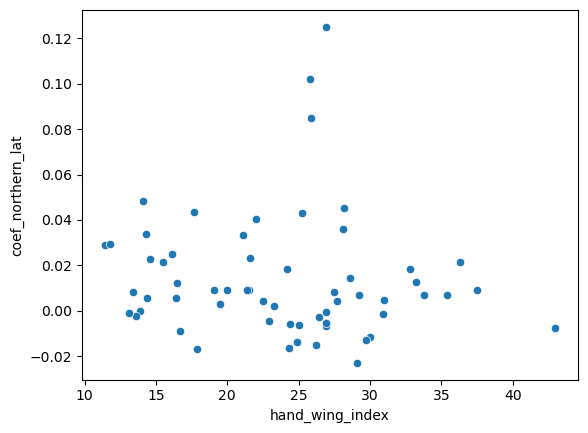

In [1154]:
sns.scatterplot(data = species_summary,
               y = 'coef_northern_lat',
               x = 'hand_wing_index');

<AxesSubplot:xlabel='hand_wing_index', ylabel='range_size'>

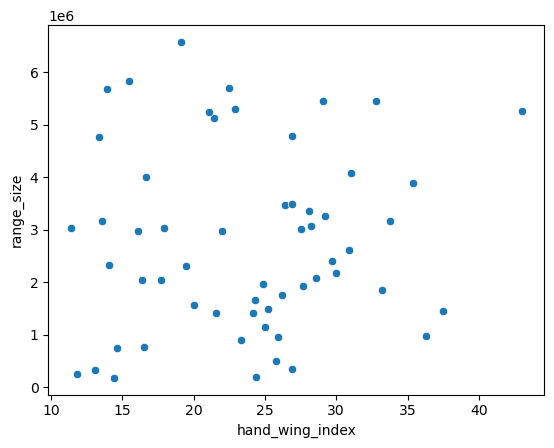

In [527]:
sns.scatterplot(data = species_summary,
               y = species_summary.query('range_size < 2 * 10 **7')['range_size'],
               x = 'hand_wing_index')

In [ ]:
species_summary['standardized_range_size','standardized_hand_wing_index','standardized_range_size']

In [1192]:
def z_score(df,column):
    standardized_col =(df[column] - df[column].mean()) / df[column].std()
    return standardized_col

In [1193]:
species_summary['standardized_range_size'] = z_score(species_summary, 'range_size')
species_summary['standardized_hand_wing_index'] = z_score(species_summary, 'hand_wing_index')
species_summary['standardized_max_lat'] = z_score(species_summary, 'max_lat')

In [1194]:
species_summary

common_name              scientific_name  coef_mean_lat  \
0              Orchard Oriole              Icterus spurius       0.033245   
1      Red-bellied Woodpecker         Melanerpes carolinus       0.036726   
2       Red-headed Woodpecker   Melanerpes erythrocephalus      -0.062740   
3            Kentucky Warbler           Geothlypis formosa      -0.016856   
4     Yellow-throated Warbler           Setophaga dominica       0.009569   
5              Hooded Warbler            Setophaga citrina       0.015900   
6             Prairie Warbler           Setophaga discolor      -0.039698   
7        Prothonotary Warbler          Protonotaria citrea       0.020633   
8          Acadian Flycatcher          Empidonax virescens      -0.010884   
9    Great Crested Flycatcher           Myiarchus crinitus      -0.049422   
10           White-eyed Vireo                Vireo griseus       0.003834   
11      Yellow-throated Vireo             Vireo flavifrons      -0.020739   
12                   Bobolink        Dolichonyx oryzivorus       0.013550   
13           Eastern Bluebird                Sialia sialis      -0.018240   
14                 Dickcissel              Spiza americana       0.019421   
15             Summer Tanager                Piranga rubra       0.019019   
16            Scarlet Tanager             Piranga olivacea      -0.026255   
17             Indigo Bunting             Passerina cyanea      -0.010925   
18          Northern Cardinal        Cardinalis cardinalis      -0.004144   
19                Wood Thrush         Hylocichla mustelina      -0.028880   
20             Brown Thrasher              Toxostoma rufum      -0.012669   
21            Tufted Titmouse           Baeolophus bicolor      -0.012367   
22         Carolina Chickadee         Poecile carolinensis      -0.005321   
23              Carolina Wren     Thryothorus ludovicianus       0.022168   
24      Brown-headed Nuthatch                Sitta pusilla       0.007487   
25               Oak Titmouse         Baeolophus inornatus       0.011044   
26             Turkey Vulture               Cathartes aura       0.046776   
27                  Fish Crow            Corvus ossifragus       0.051665   
28              Black Vulture             Coragyps atratus       0.022830   
29              Field Sparrow             Spizella pusilla      -0.015024   
30             Eastern Towhee      Pipilo erythrophthalmus       0.035802   
31       Yellow-billed Cuckoo          Coccyzus americanus      -0.002657   
32                 Sedge Wren        Cistothorus platensis       0.016108   
33         Swainson's Warbler      Limnothlypis swainsonii       0.005769   
34        Worm-eating Warbler       Helmitheros vermivorum      -0.015152   
35           Cerulean Warbler            Setophaga cerulea      -0.012124   
36      Golden-winged Warbler        Vermivora chrysoptera       0.081549   
37        Blue-winged Warbler         Vermivora cyanoptera      -0.004195   
38      Louisiana Waterthrush           Parkesia motacilla      -0.013914   
39               Pine Warbler              Setophaga pinus       0.032038   
40         Eastern Wood-Pewee              Contopus virens      -0.000337   
41          Bachman's Sparrow           Peucaea aestivalis       0.026809   
42            Northern Parula          Setophaga americana       0.068843   
43  Scissor-tailed Flycatcher          Tyrannus forficatus       0.020427   
44            Painted Bunting              Passerina ciris       0.007849   
45        Grasshopper Sparrow        Ammodramus savannarum       0.017482   
46               Lark Bunting      Calamospiza melanocorys      -0.042692   
47            Baird's Sparrow            Centronyx bairdii       0.019751   
48           Cassin's Sparrow             Peucaea cassinii       0.004730   
49      Blue-gray Gnatcatcher          Polioptila caerulea      -0.007000   
50               Black Phoebe           Sayornis nigricans       0.007942   
51            

In [735]:
%%capture

"""Define a formula for multiple regression. Use the Patsy package to define a design matrix."""

expr = """ coef_northern_lat ~ C(migration, Treatment(1)) + C(habitat, Treatment(1)) + beak_depth + hand_wing_index """

In [1197]:
expr = """ coef_northern_lat ~  C(migration, Treatment(1)) + C(habitat, Treatment(1)) + standardized_range_size + standardized_hand_wing_index"""

In [1198]:
model = smf.ols(formula=expr, data=species_summary).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      coef_northern_lat   R-squared:                       0.341
Model:                            OLS   Adj. R-squared:                  0.252
Method:                 Least Squares   F-statistic:                     3.844
Date:                Mon, 09 Jan 2023   Prob (F-statistic):            0.00194
Time:                        18:14:03   Log-Likelihood:                 144.28
No. Observations:                  60   AIC:                            -272.6
Df Residuals:                      52   BIC:                            -255.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

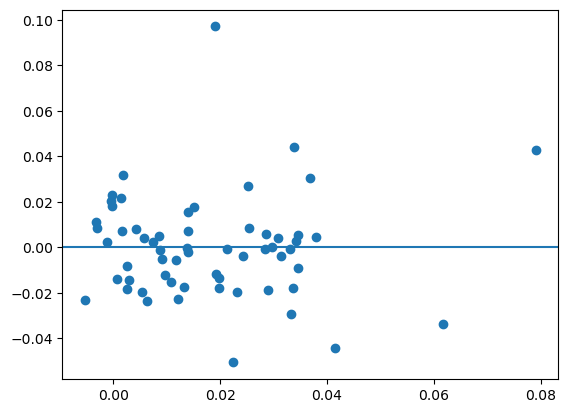

In [1830]:
"""Residuals plot on multiple regression result. A random pattern indicates the appropriateness of the model."""

plt.scatter(model.fittedvalues,model.resid)
plt.axhline()

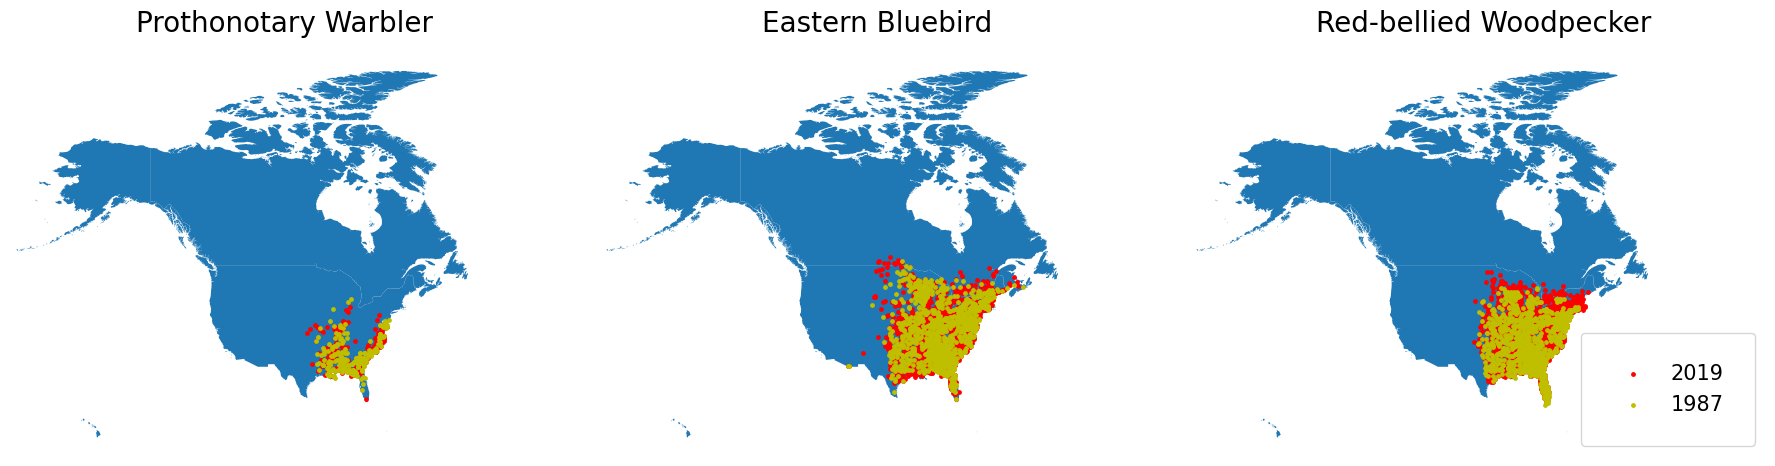

In [793]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (18,18))
world.query('COUNTRY == "United States"|COUNTRY =="Canada"').plot(ax = axs[0])


axs[0].scatter(y = us_canada_obs.query('year == 2019 & common_name == "Prothonotary Warbler"')['latitude'], 
           x = us_canada_obs.query('year == 2019 & common_name == "Prothonotary Warbler"')['longitude'],
           color = 'r',
           s = 6)
axs[0].scatter(y = us_canada_obs.query('year == 1987 & common_name == "Prothonotary Warbler"')['latitude'], 
           x = us_canada_obs.query('year == 1987 & common_name == "Prothonotary Warbler"')['longitude'],
           color = 'y',
           s = 6)
axs[0].text(x = -145, y = 90, s = 'Prothonotary Warbler', size = 20)
axs[0].set_xlim([-180,-20])
axs[0].axis('off')

world.query('COUNTRY == "United States"|COUNTRY =="Canada"').plot(ax = axs[1])


axs[1].scatter(y = us_canada_obs.query('year == 2019 & common_name == "Eastern Bluebird"')['latitude'], 
           x = us_canada_obs.query('year == 2019 & common_name == "Eastern Bluebird"')['longitude'],
           color = 'r',
           s = 6,
          label = 2019)
axs[1].scatter(y = us_canada_obs.query('year == 1987 & common_name == "Eastern Bluebird"')['latitude'], 
           x = us_canada_obs.query('year == 1987 & common_name == "Eastern Bluebird"')['longitude'],
           color = 'y',
           s = 6, 
          label = 1987)
axs[1].text(x = -135, y = 90, s = 'Eastern Bluebird', size = 20)
axs[1].set_xlim([-180,-20])
axs[1].axis('off');

world.query('COUNTRY == "United States"|COUNTRY =="Canada"').plot(ax = axs[2])


axs[2].scatter(y = us_canada_obs.query('year == 2019 & common_name == "Red-bellied Woodpecker"')['latitude'], 
           x = us_canada_obs.query('year == 2019 & common_name == "Red-bellied Woodpecker"')['longitude'],
           color = 'r',
           s = 6,
          label = 2019)
axs[2].scatter(y = us_canada_obs.query('year == 1987 & common_name == "Red-bellied Woodpecker"')['latitude'], 
           x = us_canada_obs.query('year == 1987 & common_name == "Red-bellied Woodpecker"')['longitude'],
           color = 'y',
           s = 6, 
          label = 1987)
axs[2].text(x = -145, y = 90, s = 'Red-bellied Woodpecker', size = 20)
axs[2].set_xlim([-180,-20])
axs[2].legend(loc = 4, borderpad = 1.5, fontsize = 15)
axs[2].axis('off');
plt.tight_layout()